# Housing price prediction project

## Introduction

Crucially affected by the stagnant supply and growing demand due to the advancing of the neoliberal thought that infamously argues that ‘there is no such thing as society’ (Thatcher, 1987), the housing market in the Global North has reached a point of no return, as houses haven’t been this unaffordable since the 19th century (Head, 2024).

While most studies correctly contend that house price prediction models can assist real estate professionals in making informed decisions, or mortgage lenders in ‘evaluating loan applications and determining appropriate interest rates’ (Sharma et al., 2024), I argue that it is not just the wealthy that could benefit from the outcomes of a machine learning (ML) model. As obtaining one’s housing is increasingly unachievable for an average worker, with prices ‘currently sitting at 8.8 times the average earnings, more than doubling since the 1970s’ (Jones, 2023), instead of unearthing more ways in which real estate developers or mortgage lenders could benefit, throughout this report I aim to focus on ways in which those facing
housing affordability challenges could be assisted instead.

Consisting of 2930 entities and 84 features, the Ames Housing dataset describes an abundance of aspects regarding the residential homes in Ames, IA, such as house characteristics, location, or sale price. Located in the central US, the city’s citizens are said to have been struggling with housing costs for over 10 years now (Brocker 2024), as many of them cannot afford to purchase a home – it was estimated that in 2021 40% of the residents rented their housing, while an individual median income was around $20,000 (United States Census Bureau, 2023).

To assist the residents of Ames in finding an affordable housing option, my ML model aims not only at finding patterns correlating with lower costs but also at identifying affordable areas of the city, by predicting house prices based on different features which then could be aggregated by the neighbourhoods to identify budget-friendly areas. Understanding which features impact the price of the house could assist the poor in an informed decision-making process that maximises their limited resources and supports them in financial planning, as
well as negotiating better deals.

## Methodology

To find the best-performing model for the house price prediction, various regression techniques were compared:

### Lasso and Ridge Regression Models

As regularized versions of linear regression, lasso and ridge regression use the same formula as Linear Regression to predict values, however, add different regularization terms (L1 and L2) to the cost function, forcing the machine learning algorithm ‘to not only fit the data but also keep the model weights as small as possible’ (Géron, 2019). As a consequence of L1 regularization certain features are ignored by the model as coefficients are equal to 0, L2 shrinks them without completely discarding any features (Ahrens et al., 2022).Tuning the hyperparameter α allows to control how much the model should be regularized – the less restricted (closer to 0), the more likely it will be to overfit and remind of a linear regression model (Müller and Guido, 2017). It is usually recommended to choose lasso or ridge regression over linear regression, as despite all of them being easy to interpret, the latter has no parameters which does not allow for control of the model complexity.

### Random Forest Regressor

Addressing the overfitting issue of the decision trees, random forest is an ensemble method that combines a collection of slightly different decision trees that are the result of bootstrap sampling. According to the method, averaging the result of many trees that all overfit differently brings the best result by the ‘reduction in overfitting, while retaining the predictive power of the trees’ (Müller and Guido, 2017). While extremely powerful and widely used,
random forest regressors tend to require more memory, don’t perform well on very high dimensional data, and are slower than linear models to train or predict.

### Ada Boost Regressor
An ensemble method combining several weak learners into a strong learner is the main idea behind an approach called boosting, in which each consecutively trained predictor aims at correcting its forerunner. Ada Boost regressor does so by constantly updating the instance weights and gradually adding predictors to the ensemble, making it overall perform better. While characterised by an inherent regularization effect and simplicity, the method cannot be
parallelized since ‘each predictor can only be trained after the previous predictor has been trained and evaluated’ (Géron, 2019), resulting in poor scalability.

### Gradient Boosting Regressor

Being a different Boosting algorithm, instead of gradually updating the instance weights, Gradient Boosting works by fitting new predictors ‘to the residual errors made by the previous predictor’ (Géron, 2019). As frequent winners of machine learning competitions, they are characterised by better performance than random forests, however, are also more sensitive to the parameter settings making them harder to properly train (Ahrens et al., 2022).

### Extreme Gradient Boosting (XGBoost)
An improvement to Gradient Boosting (Fan et al., 2018) that pushes the limits of computation to achieve gains in accuracy and speed is referred to as an Extreme Gradient Boosting algorithm (Wade and Glynn, 2020). Characterised by crushing its competition, XGBoost gives state-of-art results on a wide range of issues and was recognised as ‘an optimal house price prediction algorithm’ by Sharma et al. (2023). While scalable and fast, it is also resourcefully expensive and a complex algorithm, that requires a longer training time.

### Stacking Regressor

Argued to be a more complex version of the cross-validation (Wolpert, 1992), stacked generalisation works by combining predictions made by multiple base learners (‘level 0’ models) in an ensemble to ‘achieve more accurate predictions than could be produced by any of the component estimators’ (Ahrens et al., 2022). While producing more precise predictions than most ensemble methods, stacking’s performance was proved to be less stable, and not as
efficient (Graczyk et al., 2010).

In [1]:
# Importing all tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, cross_val_predict,RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy import stats
import warnings

In [6]:
# EDA
df = pd.read_csv('AmesHousing.csv')

In [ ]:
df.shape

(2930, 84)

In [ ]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Longitude,Latitude,price_cat
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035,3
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014,2
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659,2
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245,3
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 85 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Order            2930 non-null   int64   
 1   PID              2930 non-null   int64   
 2   MS SubClass      2930 non-null   int64   
 3   MS Zoning        2930 non-null   object  
 4   Lot Frontage     2440 non-null   float64 
 5   Lot Area         2930 non-null   int64   
 6   Street           2930 non-null   object  
 7   Alley            198 non-null    object  
 8   Lot Shape        2930 non-null   object  
 9   Land Contour     2930 non-null   object  
 10  Utilities        2930 non-null   object  
 11  Lot Config       2930 non-null   object  
 12  Land Slope       2930 non-null   object  
 13  Neighborhood     2930 non-null   object  
 14  Condition 1      2930 non-null   object  
 15  Condition 2      2930 non-null   object  
 16  Bldg Type        2930 non-null   object  


In [ ]:
df['Sale Condition'].value_counts()

Sale Condition
Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: count, dtype: int64

In [7]:
# Data types
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:", len(object_cols))

num = (df.dtypes == 'int') | (df.dtypes == 'float')
num_cols = list(num[num].index)
print("Numerical variables:", len(num_cols))

Categorical variables: 43
Numerical variables: 41


In [8]:
numerical_data = df.select_dtypes(['int64', 'float64'])

numerical_data.describe()

numerical_data.shape

(2930, 41)

In [9]:
# Correlation
corr_matrix=numerical_data.corr()
print(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Latitude           0.290891
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Screen Porch       0.112151
Pool Area          0.068403
Mo Sold            0.035259
3Ssn Porch         0.032225
BsmtFin SF 2       0.005891
Misc Val          -0.015691
Yr Sold           -0.030569
Order             -0.031408
Bsmt Half Bath    -0.035835
Low Qual Fin SF   -0.037660
MS SubClass       -0

,count
price_cat,
100000-200000,0.621502
200000-300000,0.213993
0-100000,0.086007
300000-400000,0.056655
400000+,0.021843


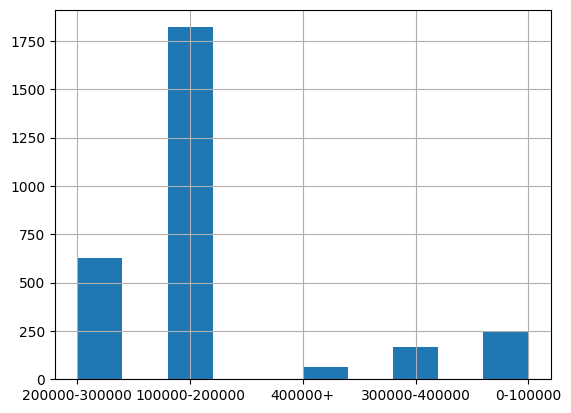

In [10]:
#To make sure test set representative of SalePrice categories
df['price_cat'] = pd.cut(df['SalePrice'], bins=[0., 100000, 200000, 300000, 400000, np.inf], labels=['0-100000','100000-200000','200000-300000','300000-400000','400000+'])
df['price_cat'].hist()
df['price_cat'].value_counts()/len(df)

In [11]:
# Split
split=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['price_cat']):
  strat_train=df.loc[train_index]
  strat_test=df.loc[test_index]

ntrain = strat_train.shape
ntest = strat_test.shape

print("Train data size is : {}".format(ntrain))
print("Test data size is : {}".format(ntest))

Train data size is : (2344, 85)
Test data size is : (586, 85)


In [12]:
#Check if same proportions
strat_test['price_cat'].value_counts()/len(strat_test)

,count
price_cat,
100000-200000,0.621160
200000-300000,0.213311
0-100000,0.087031
300000-400000,0.056314
400000+,0.022184


In [13]:
# Use copies to work on
housing = strat_train.copy()
housing_test = strat_test.copy()

In [ ]:
housing.shape

(2344, 85)

In [ ]:
housing_test.shape

(586, 85)

## Exploratory Data Analysis

Concerned with discovering what data ‘seems to say’ (Tukey, 1977), the process of the prediction task began with exploratory data analysis to better understand its structure and detect potential anomalies or patterns. The Ames Housing dataset contained 2930 observations and 84 features at the beginning of the analysis.

Following the separation of the numerical and categorical features, the former were visualised using histograms and checked for multicollinearity with the target variable ‘SalePrice’, not only to better understand the numerical attributes but also relationships between them as they could affect the precision of the estimate coefficients. As none of the correlations were higher than 0.8, it was assumed that no severe multicollinearity was present
(Shrestha, 2020) and none of the attributes were dropped. With scores of respectively 0.799, 0.706 and 0.647, the attributes most likely to predict the price of the sale were its overall quality, above-grade living area, and size of garage in car capacity.

Following, to avoid the data snooping bias, as well as preserve the percentage of samples for each category and make the sets representative of the whole dataset, a test set containing 20% of it was created and stratified by formerly binned SalePrice categories. To make sure that the sets just created stay safe, copies of both were created and the training set only was used for the data visualisations.

Since I have modified the dataset to include the longitude and latitude for each property sold, a scatterplot to visualise the geographical data was used and coloured by the target variable SalePrice. According to the plot, house pricing is tied to location – the properties in the outskirts of Ames seem to be more expensive (e.g. Northridge Heights) than those located centrally (e.g. Old Town or North Ames). It could be therefore recommended to those struggling with home purchasing, to focus on the latter areas when searching for a potential home. The findings from the plot were also confirmed by checking the number of houses below the 25th percentile of the price of sale by neighbourhood – over 20% of them were found to be in Old Town and over 16% in North Ames.

<Axes: xlabel='Longitude', ylabel='Latitude'>

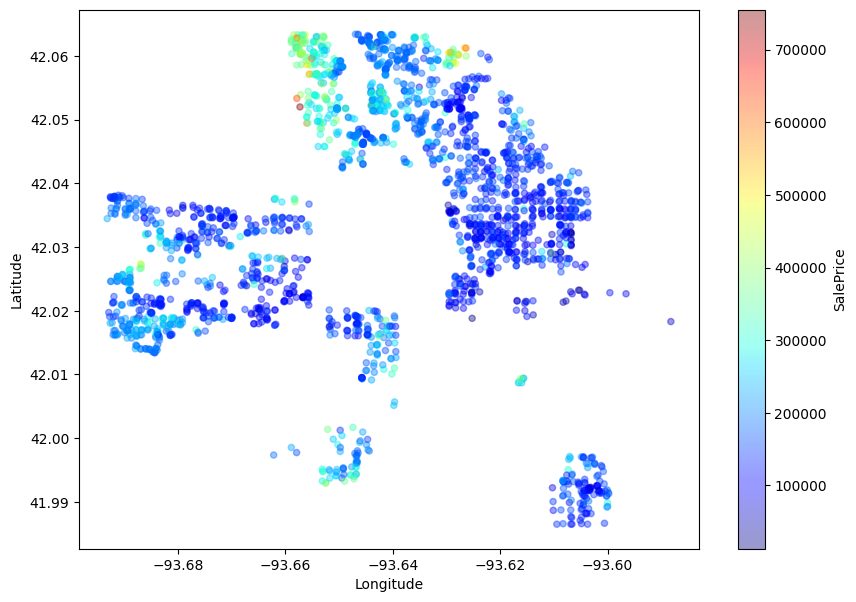

In [14]:
# Data visualisations
housing.plot(kind='scatter', x='Longitude', y='Latitude', alpha=0.4, figsize=(10,7), c='SalePrice', cmap=plt.get_cmap('jet'), colorbar=True)

In [15]:
#Check the abnormal sales neighborhoods
housing[housing['Sale Condition']=='Abnorml']['Neighborhood'].value_counts().sort_values(ascending=False)

,count
Neighborhood,
NAmes,32
OldTown,19
Edwards,14
IDOTRR,13
Sawyer,9
Mitchel,7
NWAmes,7
BrkSide,7
CollgCr,6


A plot of sale condition vs price category has confirmed that finding affordable
housing in good condition is possible, as the majority of housing under $100000 was found in the ‘normal’ sale condition category.

In [16]:
housing[housing['SalePrice']<np.quantile(housing['SalePrice'],0.25)]['Neighborhood'].value_counts().sort_values(ascending=False)
filtered_housing = housing[housing['SalePrice'] < np.quantile(housing['SalePrice'], 0.25)]
neighborhood_percentages = (filtered_housing['Neighborhood'].value_counts(normalize=True) * 100).sort_values(ascending=False)

print(neighborhood_percentages)

Neighborhood
OldTown    20.307167
NAmes      16.552901
Edwards    16.040956
IDOTRR      9.556314
BrkSide     9.044369
Sawyer      7.167235
BrDale      4.778157
MeadowV     4.266212
SWISU       3.071672
CollgCr     2.559727
Mitchel     2.047782
SawyerW     1.877133
Crawfor     0.682594
NPkVill     0.682594
NWAmes      0.511945
Blueste     0.511945
ClearCr     0.170648
Gilbert     0.170648
Name: proportion, dtype: float64


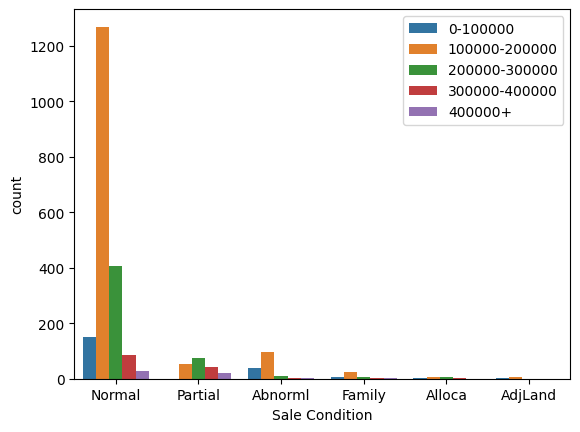

In [ ]:
sns.countplot(x='Sale Condition', hue='price_cat', data=housing)
plt.legend(loc='upper right')
plt.show()

On top of two affordable neighbourhoods already found, boxplots of the lowest 25th percentiles of prices vs neighbourhoods with overall quality of at least 5, have revealed that Meadow Village or Sawyer West could offer the most attractive deals to the buyers, as the median prices are the lowest for those neighbourhoods.

<ipython-input-17-424e5d495205>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Neighborhood', y='SalePrice', data=filtered_housing, palette='viridis', order=sorted_neighborhoods)


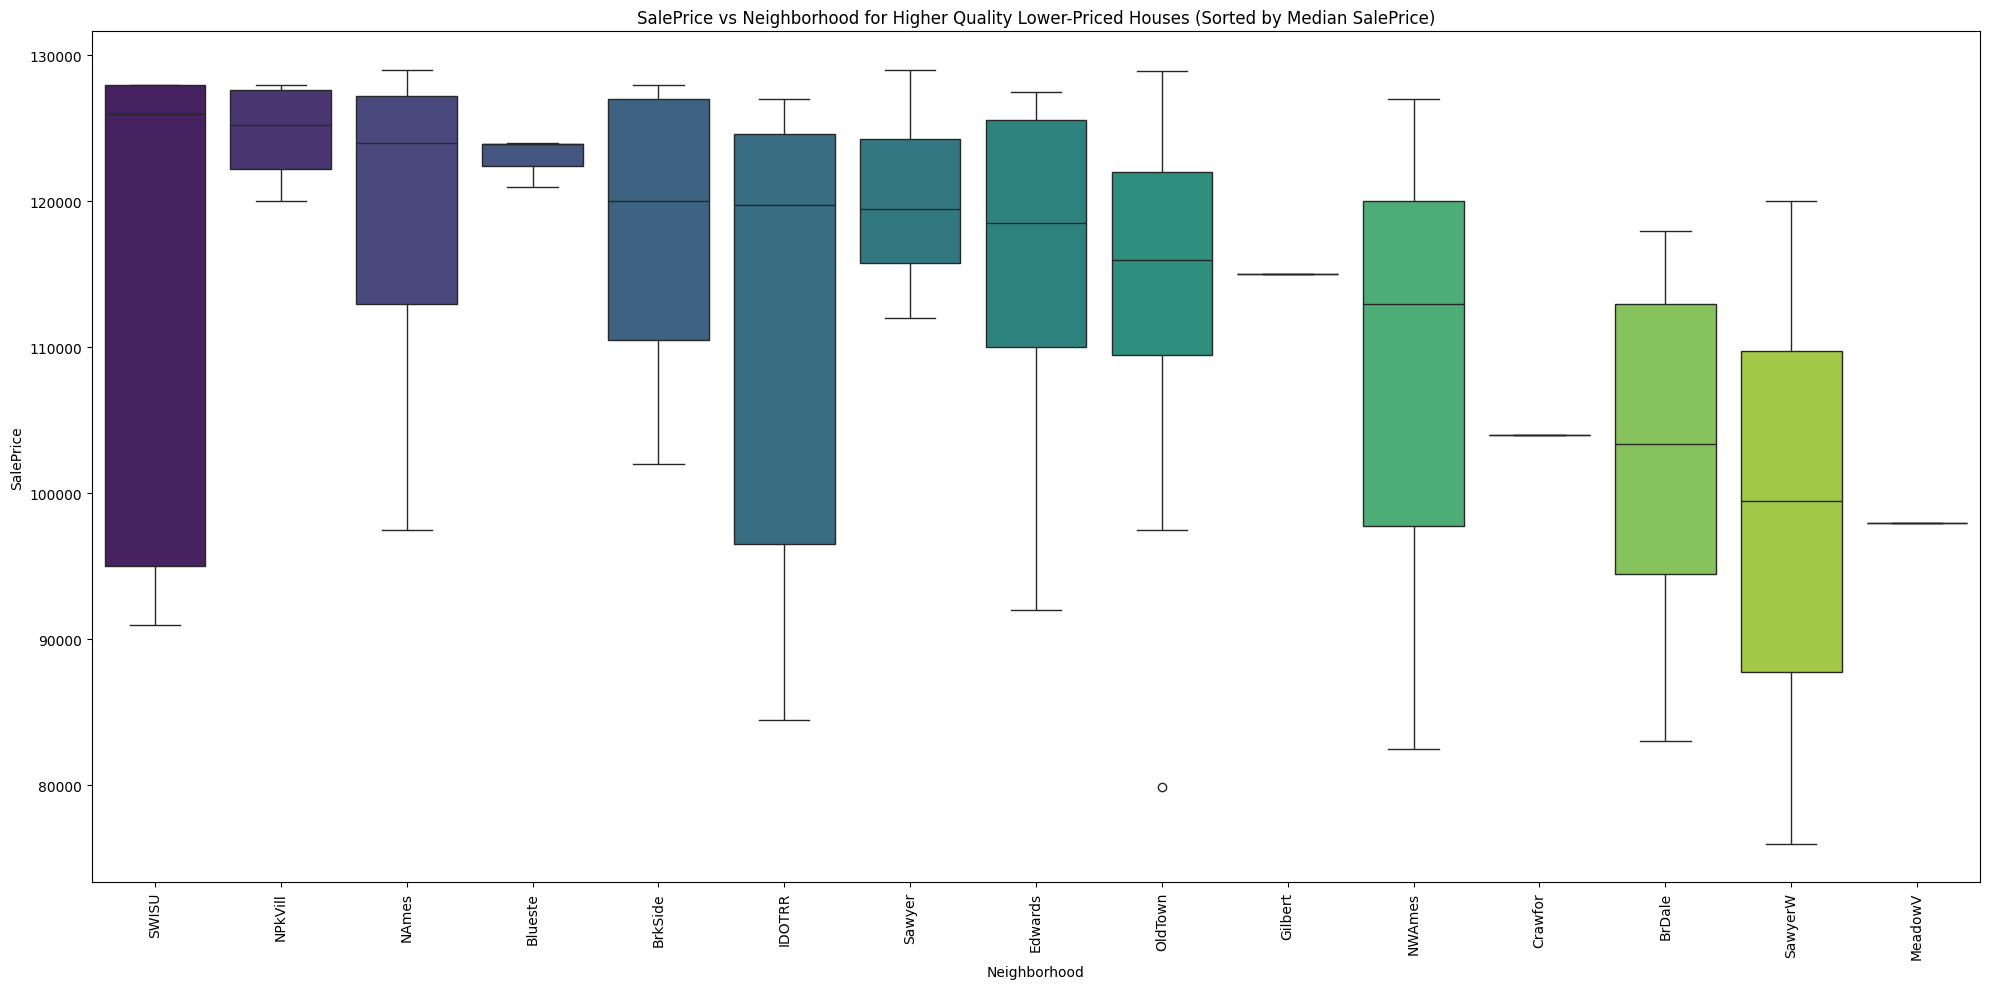

In [17]:
filtered_housing = housing[(housing['SalePrice'] < np.quantile(housing['SalePrice'], 0.25)) & (housing['Overall Qual'] > 5)]
sorted_neighborhoods = filtered_housing.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index
plt.figure(figsize=(20,10))
sns.boxplot(x='Neighborhood', y='SalePrice', data=filtered_housing, palette='viridis', order=sorted_neighborhoods)
plt.title('SalePrice vs Neighborhood for Higher Quality Lower-Priced Houses (Sorted by Median SalePrice)')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## Pre-processing
As outliers and missing values can make it ‘harder for the system to detect the underlying patterns’ (Géron, 2019) making it overfit and perform worse, it is worth taking care of these early on. Numerous outliers found by plotting the 10 features most correlated to the target variable were then removed from both training and test datasets using the standard deviation method – a cut-off for detecting outliers was specified by multiplying the standard deviation
by three.

A process of feature engineering was then applied to transform existing data into new features that not only better represent the underlying issues, but also improve the performance of a model (Ozdemir and Susarla, 2018). Numerical features representing things such as the year the property was built/sold, or scale values such as overall quality/condition were transformed to categorical. As the target variable was still characterised by a right-skewed distribution after the removal of outliers from both sets, a log transformation was applied to it. Following the transformation, the distribution of ‘SalePrice’ in both training and test sets closely resembled a normal one with skewness values of respectively -0.27 and -0.22, and kurtosis of 1.66 and 0.63.

Next, variables with either more than 80% of missing values, or bringing no value to the model (‘Order’, ‘PID’) were dropped from both sets, as that would not only further improve the performance, but also work in favour of the computational efficiency.

A full pipeline containing separate transformation pipelines of different data processing components was created for numerical and categorical variables to complete the feature engineering process. While both included an imputer as most algorithms cannot work with missing values, the numerical also consisted of a scaler - as they also don’t perform well with numerical values on different scales; and categorical of an encoder as machine learning
algorithms work best with numbers.

Following the fitting and transforming of training data, and transforming of test data, the process of feature selection took place to choose the most important predictors among all existing features and slightly reduce the dimensionality of the dataset. According to the results, the property’s sale price is mostly dependent on its above-grade living area, longitude, garage area, basement size, and the size of the garage in car capacity, as those are
characterised by the highest mutual information gain.

I have decided for my cut-off score for feature selection to be at least 0.05, meaning that any values under it would be excluded from the model. As 75 out of 624 met the criteria, the dimensionality of the dataset was significantly reduced.

In [ ]:
housing.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Longitude,Latitude
count,2344.000000,2.344000e+03,2344.000000,1953.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2324.000000,...,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000,2344.000000
mean,1465.107935,7.142664e+08,57.058447,69.226318,10151.340444,6.101962,5.574232,1971.152730,1983.932594,106.228485,...,23.773038,2.283276,16.309727,1.990188,36.296502,6.239334,2007.790529,180631.224403,-93.643153,42.034491
std,849.410020,1.886968e+08,42.464079,22.483737,7803.753482,1.408563,1.116570,30.353454,20.885266,184.531800,...,65.361392,22.493665,56.808711,33.653508,409.609691,2.695274,1.324472,79924.198033,0.025654,0.018364
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-93.693153,41.986498
25%,720.750000,5.284733e+08,20.000000,59.000000,7500.000000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129237.500000,-93.660648,42.021986
50%,1465.500000,5.354531e+08,50.000000,68.000000,9459.500000,6.000000,5.000000,1973.000000,1992.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000,-93.641909,42.034678
75%,2210.250000,9.071920e+08,70.000000,80.000000,11626.500000,7.000000,6.000000,2000.000000,2004.000000,170.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213000.000000,-93.622372,42.049816
max,2930.000000,9.241520e+08,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1012.000000,407.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,-93.588227,42.063388


Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars',
       'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath',
       'Year Remod/Add'],
      dtype='object')


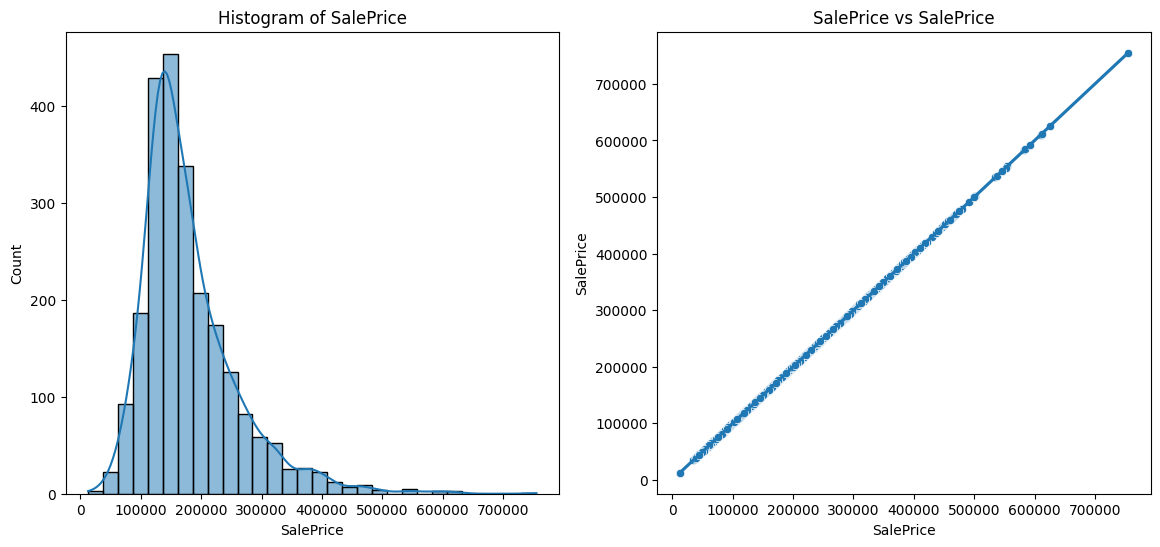

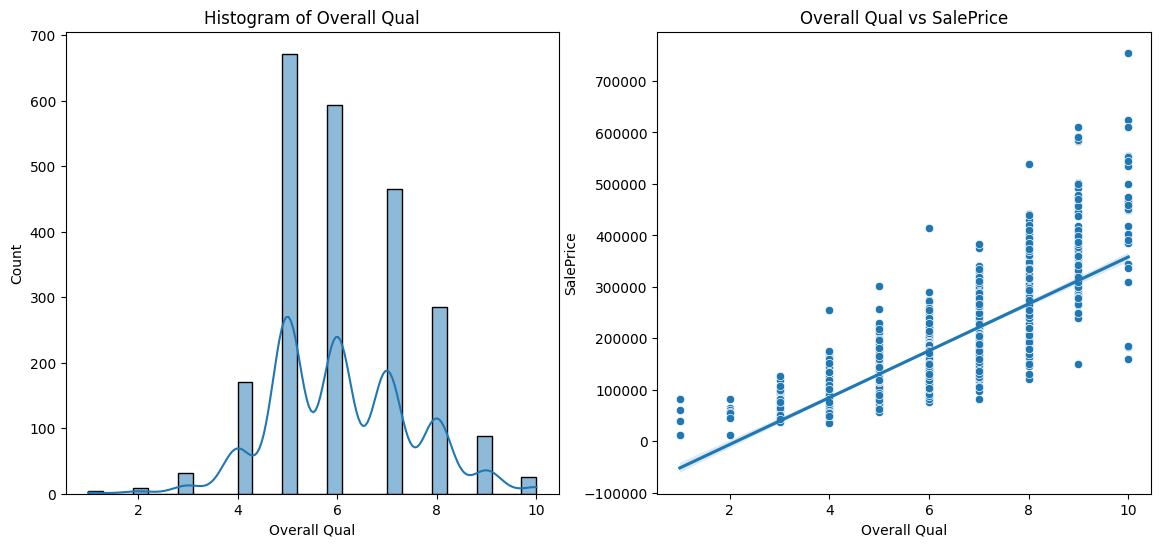

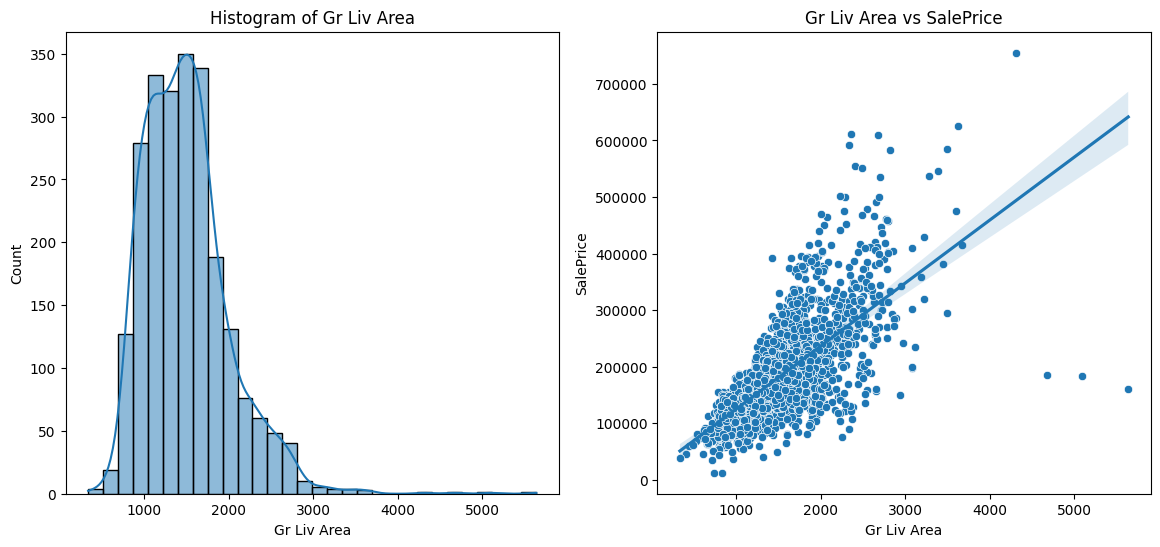

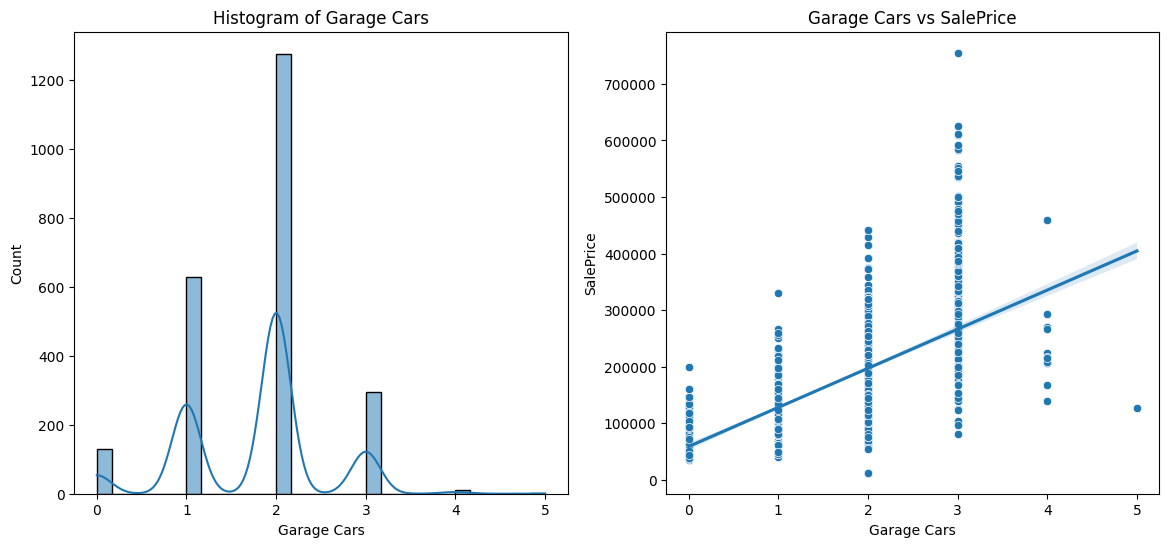

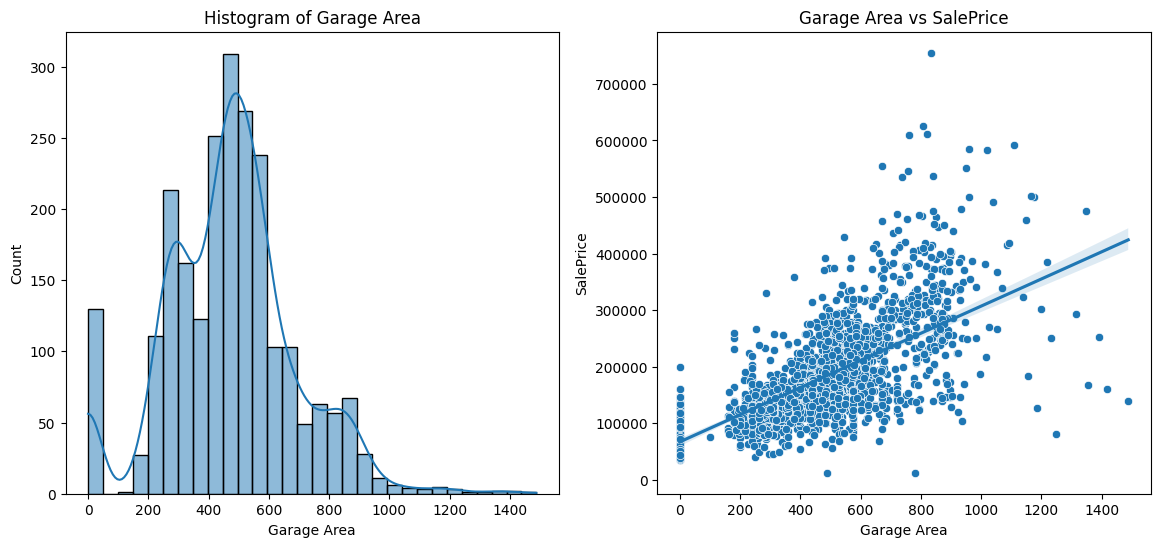

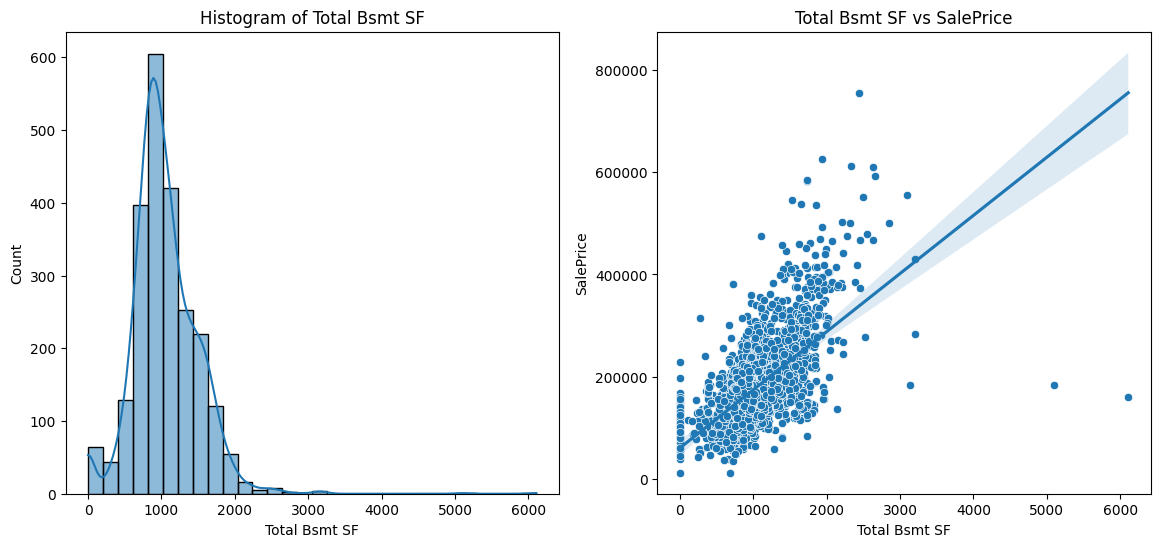

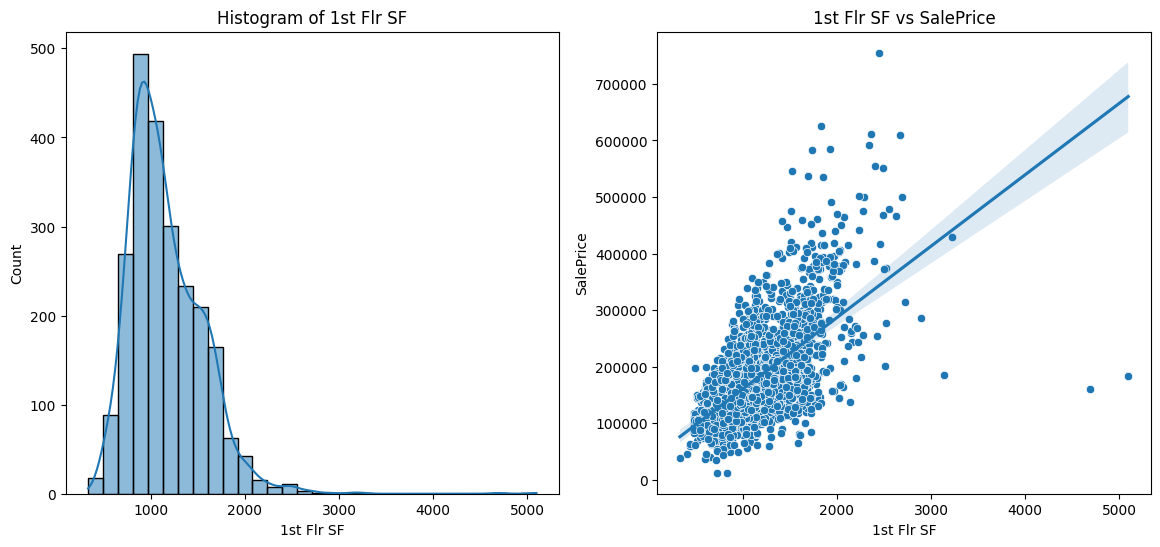

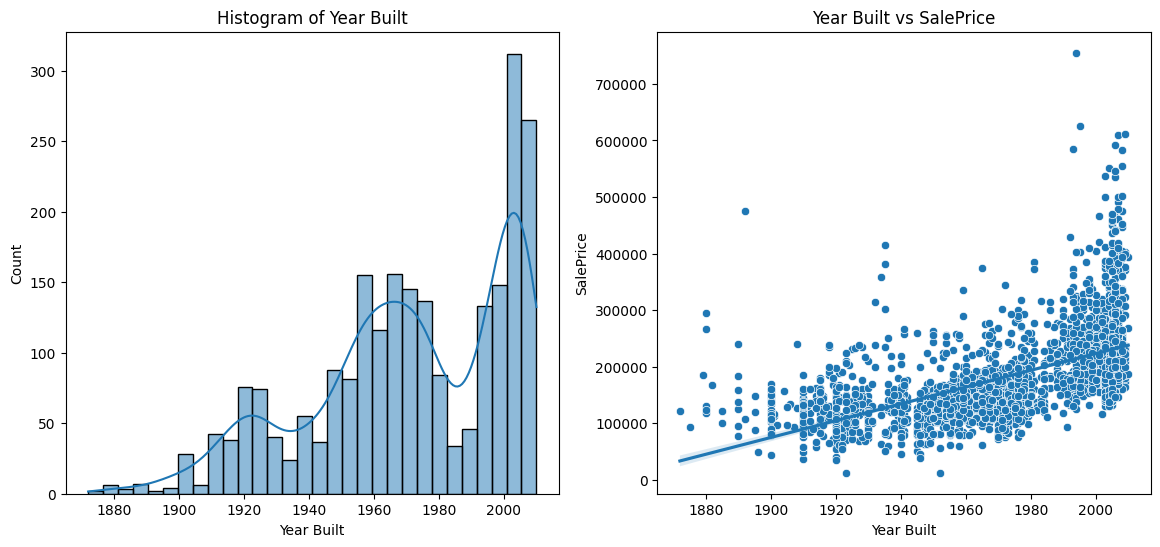

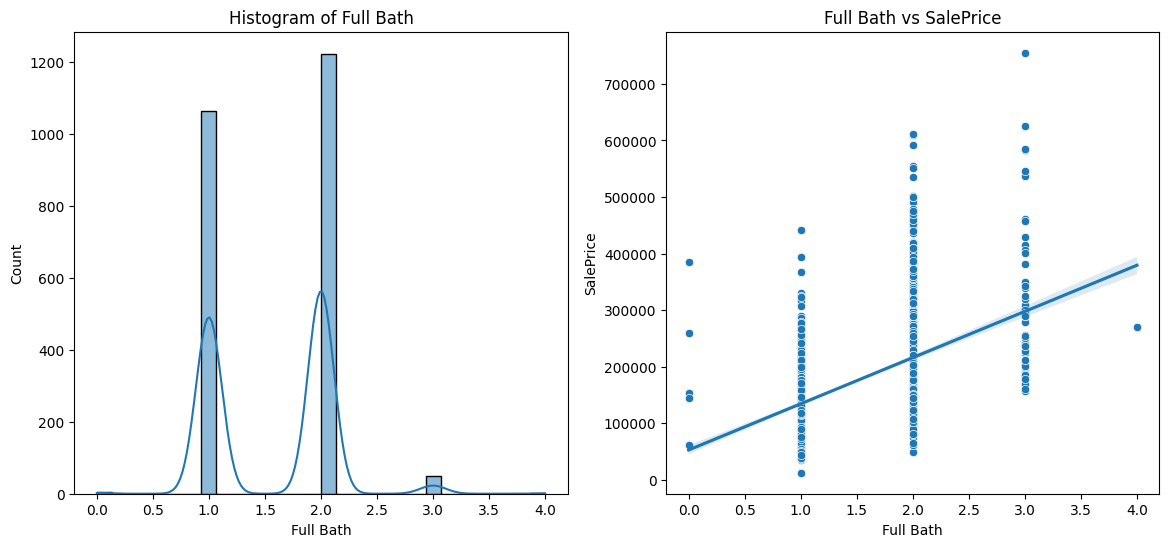

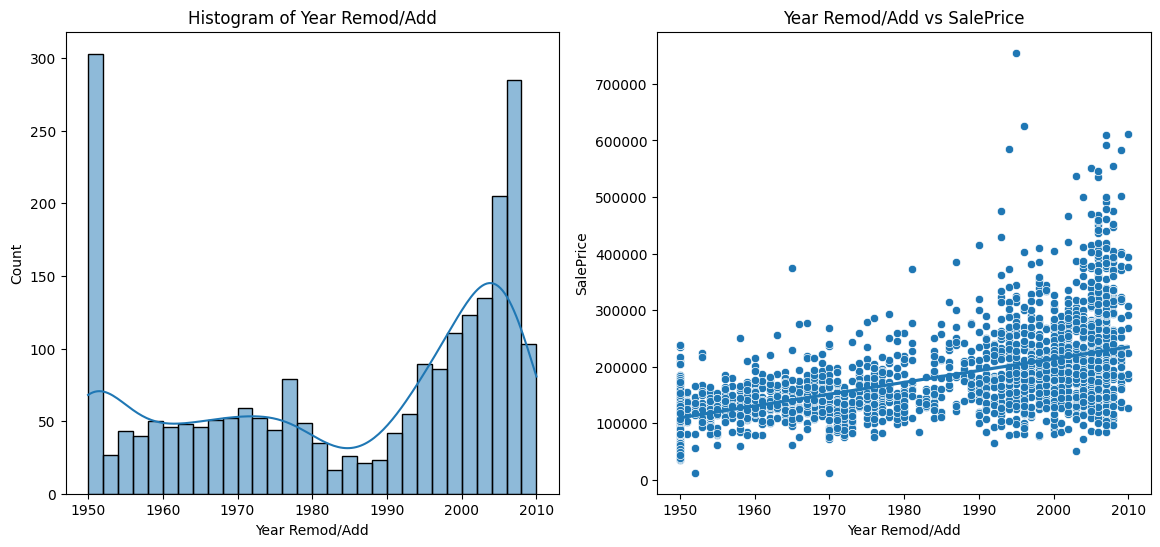

In [ ]:
cols = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index

print(cols)

for col in cols:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(housing[col], bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f'Histogram of {col}')
    ax[0].set_xlabel(col)

    sns.scatterplot(x=housing[col], y=housing['SalePrice'], ax=ax[1])
    sns.regplot(x=housing[col], y=housing['SalePrice'], scatter=False, ax=ax[1])
    ax[1].set_title(f'{col} vs SalePrice')
    ax[1].set_xlabel(col)
    ax[1].set_ylabel('SalePrice')

    plt.show()

In [18]:
# Removing outliers
mean = housing['SalePrice'].mean()
std = housing['SalePrice'].std()
cut_off = std*3

lower, upper = mean - cut_off, mean + cut_off
housing = housing[(housing['SalePrice'] < upper) & (housing['SalePrice'] > lower)]

housing.shape

(2310, 85)

In [19]:
mean = housing_test['SalePrice'].mean()
std = housing_test['SalePrice'].std()
cut_off = std*3

lower, upper = mean - cut_off, mean + cut_off
housing_test = housing_test[(housing_test['SalePrice'] < upper) & (housing_test['SalePrice'] > lower)]

housing_test.shape

(575, 85)

Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars',
       'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath',
       'Year Remod/Add'],
      dtype='object')


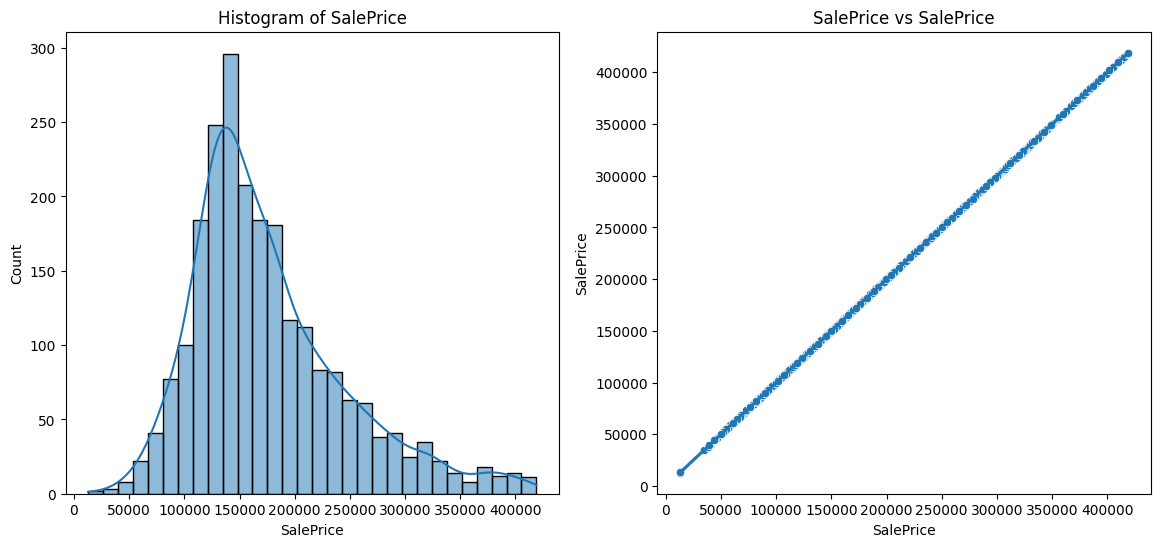

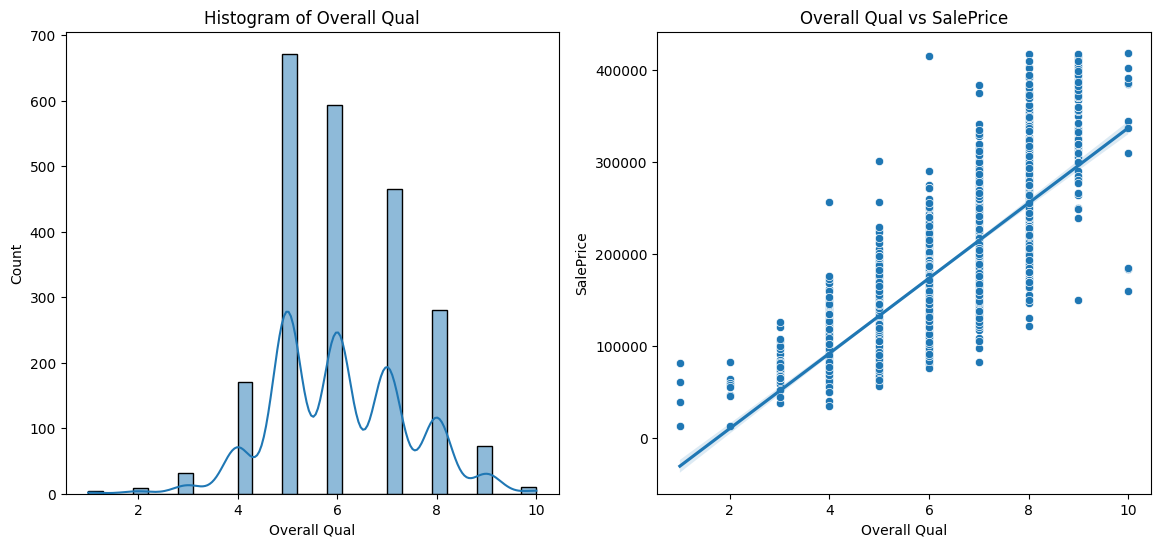

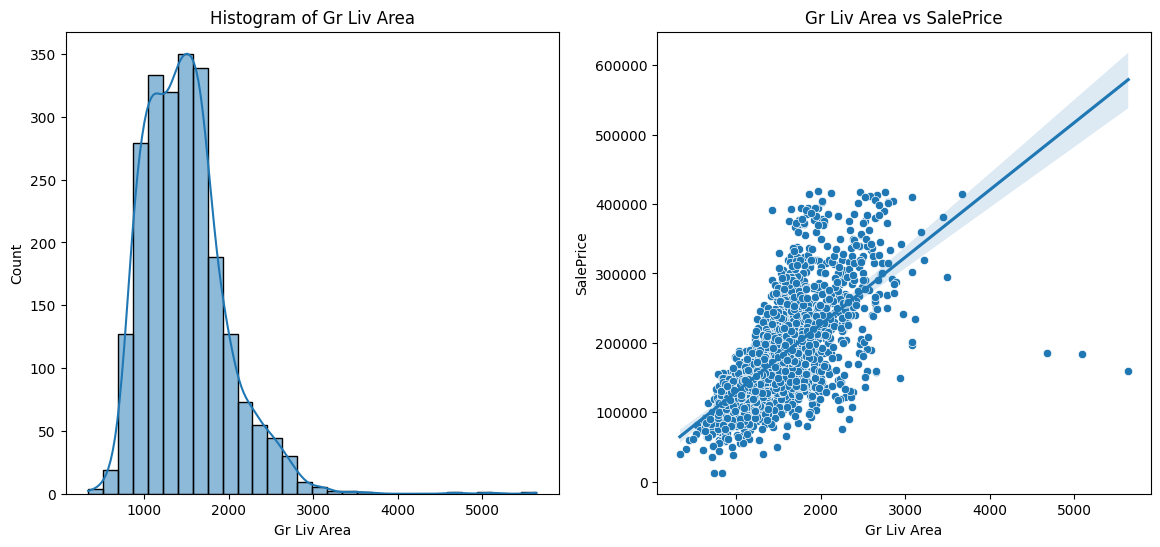

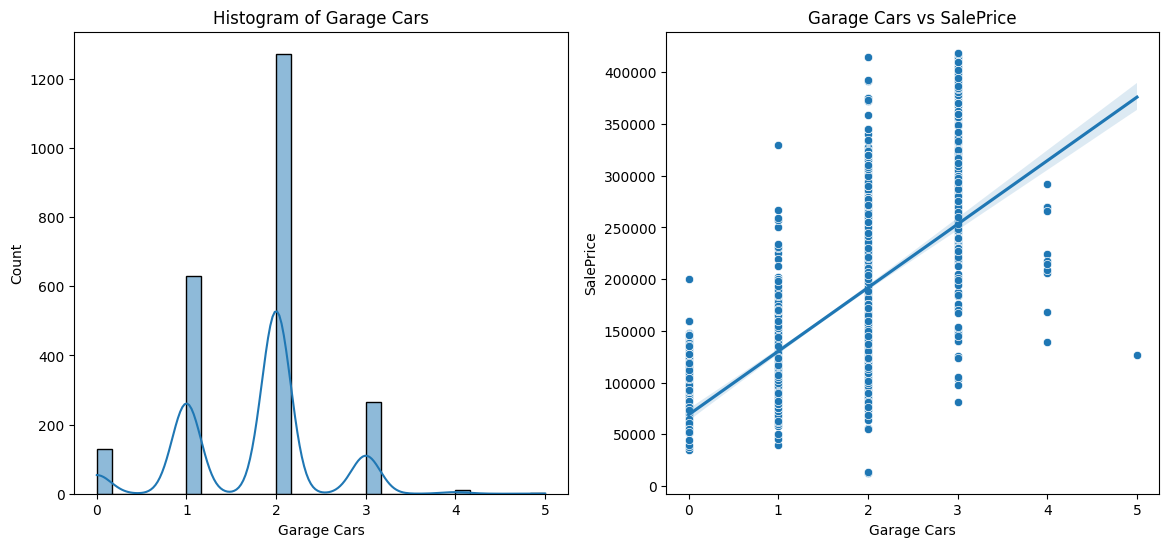

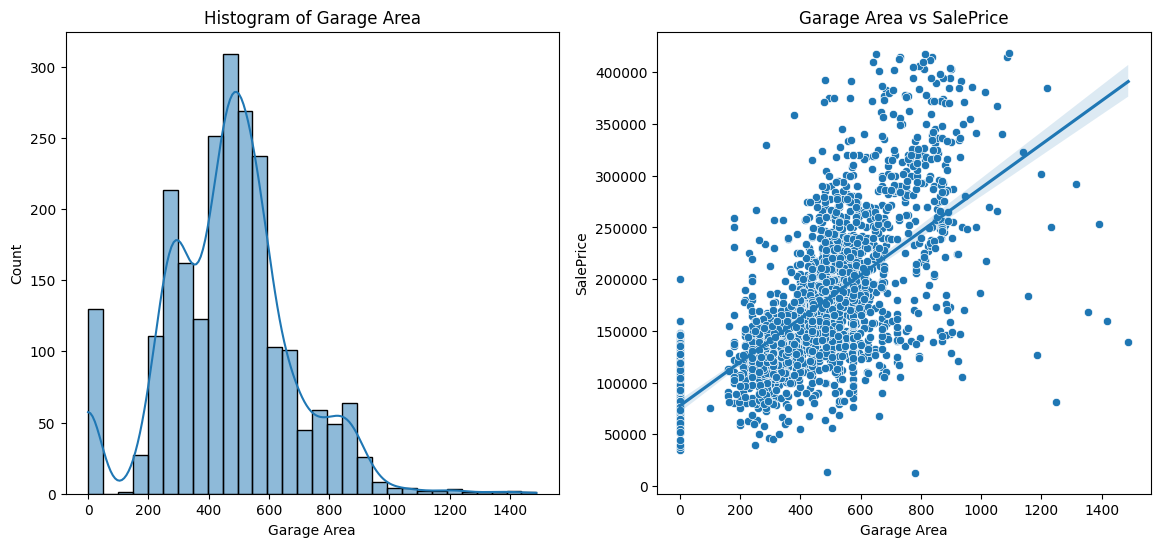

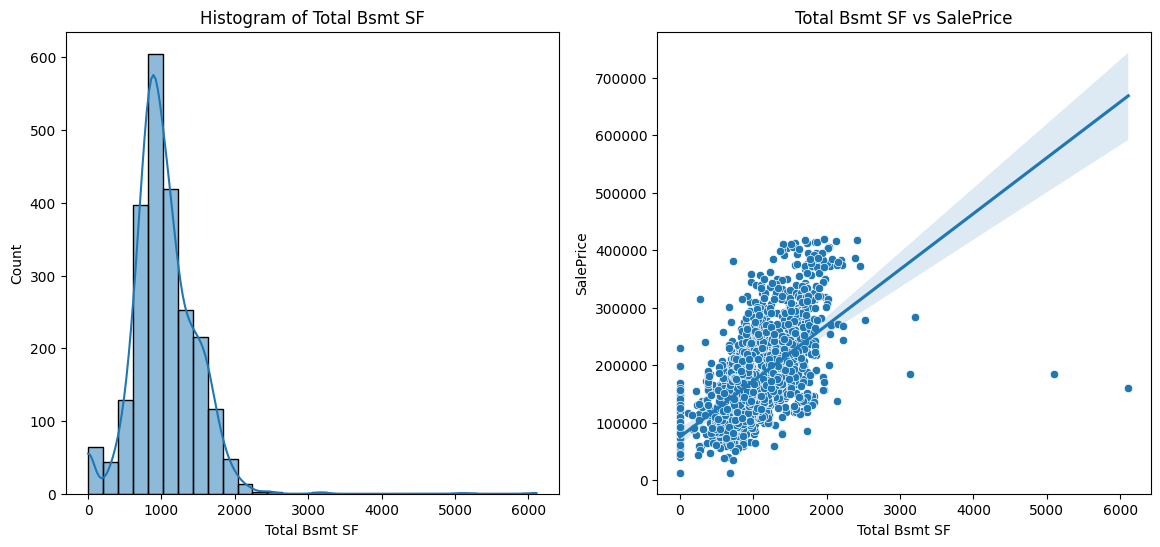

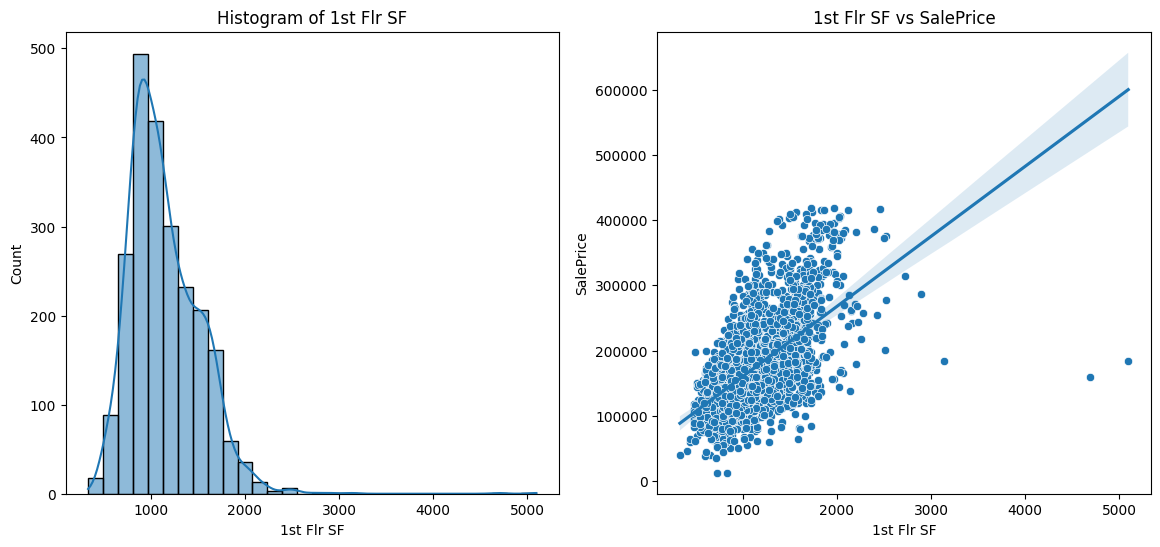

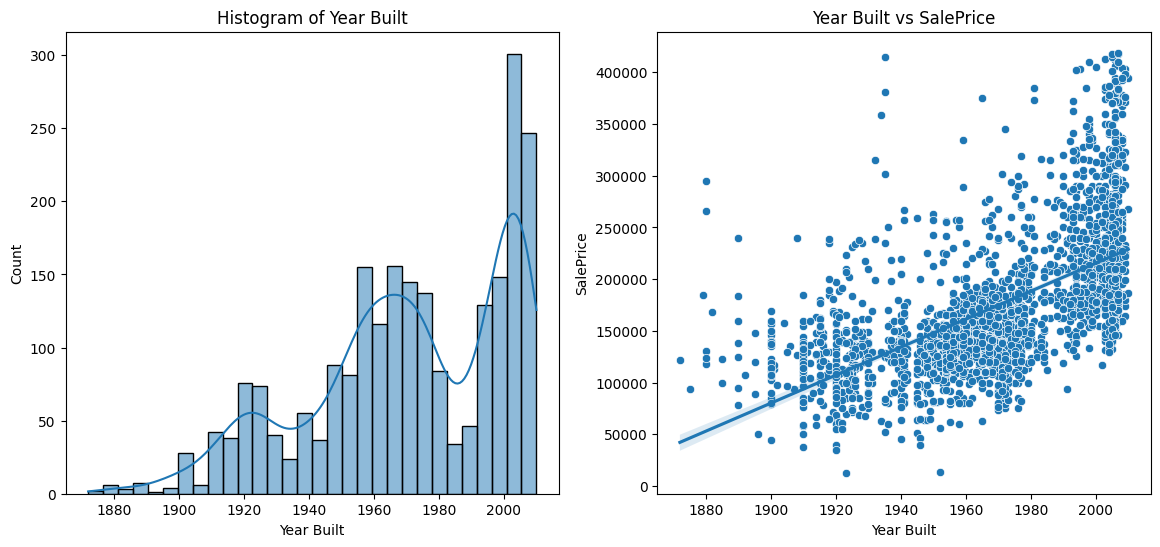

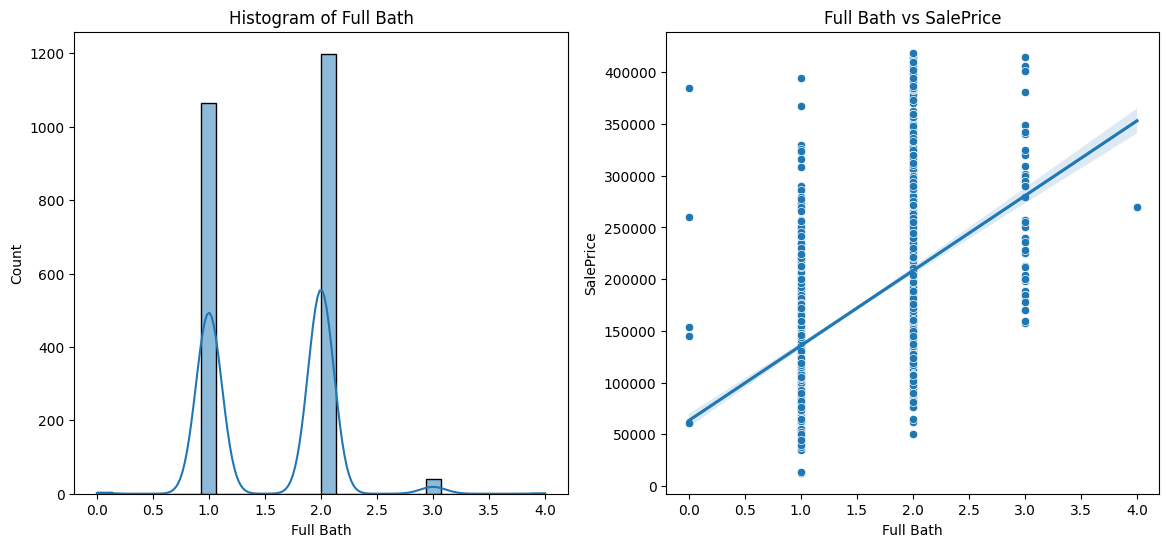

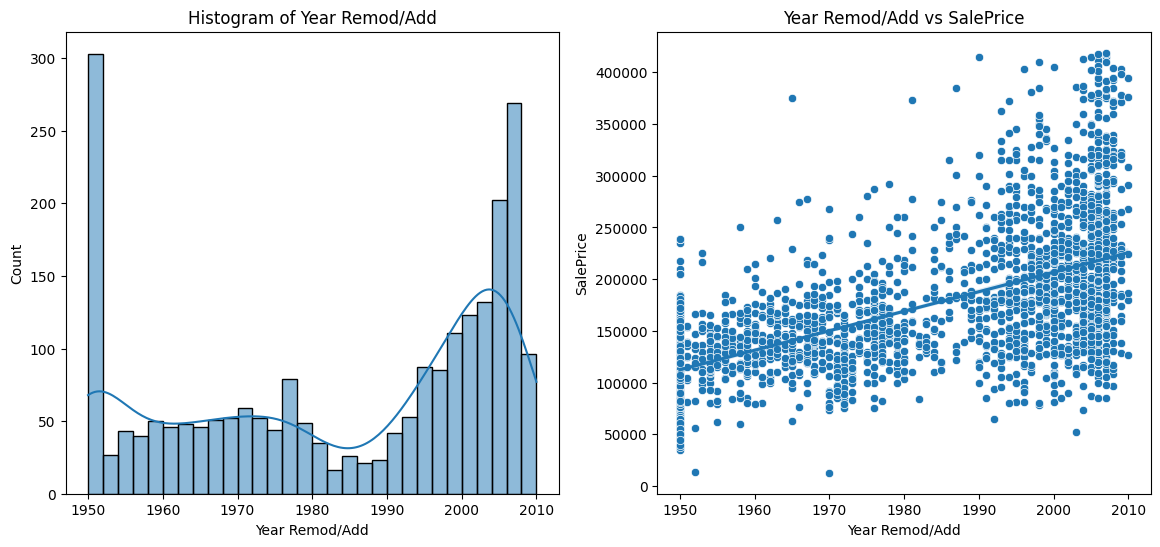

In [20]:
cols = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
print(cols)

for col in cols:
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(housing[col], bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f'Histogram of {col}')
    ax[0].set_xlabel(col)

    sns.scatterplot(x=housing[col], y=housing['SalePrice'], ax=ax[1])
    sns.regplot(x=housing[col], y=housing['SalePrice'], scatter=False, ax=ax[1])
    ax[1].set_title(f'{col} vs SalePrice')
    ax[1].set_xlabel(col)
    ax[1].set_ylabel('SalePrice')

    plt.show()

<ipython-input-21-456eb0d27fb7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housing['SalePrice'], fit=norm)
<ipython-input-21-456eb0d27fb7>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(housing_test['SalePrice'], fit=norm)


Skewness of Sale Price in the training set: 1.058581
Kurtosis of Sale Price in the training set: 1.083896
Skewness of Sale Price in the test set: 0.935560
Kurtosis of Sale Price in the test set: 0.828024


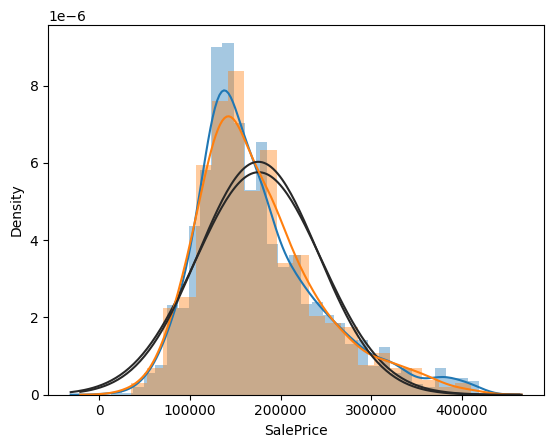

In [21]:
# Normality check

sns.distplot(housing['SalePrice'], fit=norm)
sns.distplot(housing_test['SalePrice'], fit=norm)

print("Skewness of Sale Price in the training set: %f" % housing['SalePrice'].skew()) #-0.99
print("Kurtosis of Sale Price in the training set: %f" % housing['SalePrice'].kurt()) #1.3

print("Skewness of Sale Price in the test set: %f" % housing_test['SalePrice'].skew()) #-0.99
print("Kurtosis of Sale Price in the test set: %f" % housing_test['SalePrice'].kurt()) #1.3

Skewness of Sale Price in the training set: -0.452783
Kurtosis of Sale Price in the training set: 2.492385
Skewness of Sale Price in the test set: -0.337887
Kurtosis of Sale Price in the test set: 0.879843


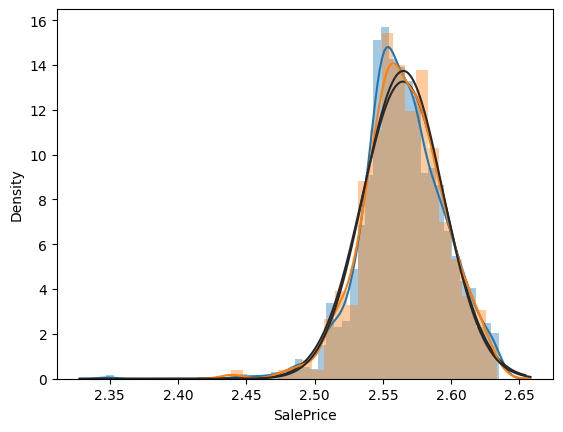

In [28]:
warnings.filterwarnings("ignore")

#Log transformation of target variable
housing["SalePrice"] = np.log1p(housing["SalePrice"])
housing_test['SalePrice'] = np.log1p(housing_test['SalePrice'])

#Check the new distribution
sns.distplot(housing['SalePrice'], fit=norm)
sns.distplot(housing_test['SalePrice'], fit=norm)

print("Skewness of Sale Price in the training set: %f" % housing['SalePrice'].skew()) #-0.99
print("Kurtosis of Sale Price in the training set: %f" % housing['SalePrice'].kurt()) #1.3

print("Skewness of Sale Price in the test set: %f" % housing_test['SalePrice'].skew()) #-0.99
print("Kurtosis of Sale Price in the test set: %f" % housing_test['SalePrice'].kurt()) #1.3

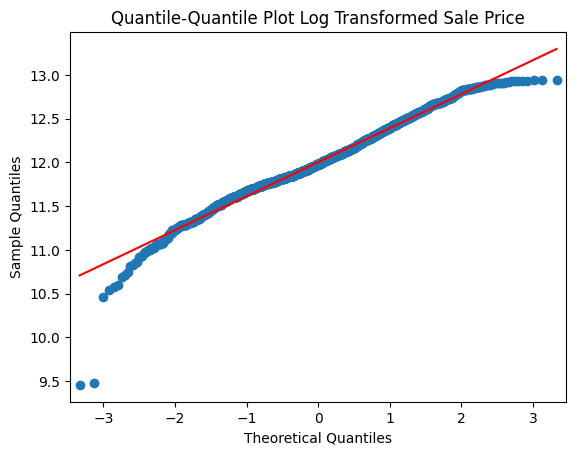

In [23]:
#Test for normality CHECK FOR OUTLIERS WITH DESCRIBE AND FIND OUT HOW TO ELIMINTAE FEATURES FOR MODELLINg
qqplot(housing['SalePrice'],line='s')
plt.title('Quantile-Quantile Plot Log Transformed Sale Price');

In [24]:
# Feature engineering
num_to_cat_list = ['MS SubClass', 'Overall Qual','Overall Cond','Year Built','Year Remod/Add','Garage Yr Blt','Mo Sold','Yr Sold']

In [25]:
def to_categorical(df,num_list):
    for feature in num_list:
        df[feature] = df[feature].astype('str')
    return df

to_categorical(housing,num_to_cat_list)
to_categorical(housing_test,num_to_cat_list)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Longitude,Latitude,price_cat
2783,2784,907201230,80,RL,42.0,10385,Pave,NaN,IR1,Lvl,...,NaN,0,4,2006,WD,Normal,12.066816,-93.687158,42.020070,100000-200000
2489,2490,532353180,80,RL,88.0,8471,Pave,NaN,IR1,Lvl,...,NaN,0,7,2006,WD,Normal,11.925042,-93.677012,42.035094,100000-200000
97,98,533212020,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,...,NaN,0,2,2010,WD,Normal,11.915058,-93.644889,42.047876,100000-200000
1060,1061,528120130,60,RL,102.0,12151,Pave,NaN,IR1,Lvl,...,NaN,0,8,2008,WD,Normal,12.845294,-93.653690,42.060766,300000-400000
2816,2817,908102020,70,RL,67.0,8777,Pave,NaN,Reg,Bnk,...,Shed,420,10,2006,WD,Normal,11.492733,-93.678267,42.019585,0-100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,1437,907181120,60,RL,68.0,8998,Pave,NaN,IR1,Lvl,...,NaN,0,6,2008,WD,Normal,12.242891,-93.690276,42.017423,200000-300000
931,932,909428240,20,RL,100.0,17500,Pave,NaN,Reg,Bnk,...,NaN,0,1,2009,WD,Normal,12.319406,-93.639407,42.012500,200000-300000
2227,2228,909455060,120,RM,35.0,3907,Pave,NaN,IR1,Bnk,...,NaN,0,3,2007,WD,Normal,12.206078,-93.645785,42.009321,100000-200000
2200,2201,909252010,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,...,NaN,0,6,2007,WD,Normal,12.072547,-93.646165,42.018921,100000-200000


In [26]:
cat = (housing.dtypes == 'object') | (housing.dtypes == 'category')
object_cols = list(cat[cat].index)
print("Categorical variables:", len(object_cols))

num = (housing.dtypes == 'int64') | (housing.dtypes == 'float64')
num_cols = list(num[num].index)
print("Numerical variables:", len(num_cols))

Categorical variables: 52
Numerical variables: 33


ValueError: num must be an integer with 1 <= num <= 44, not 45

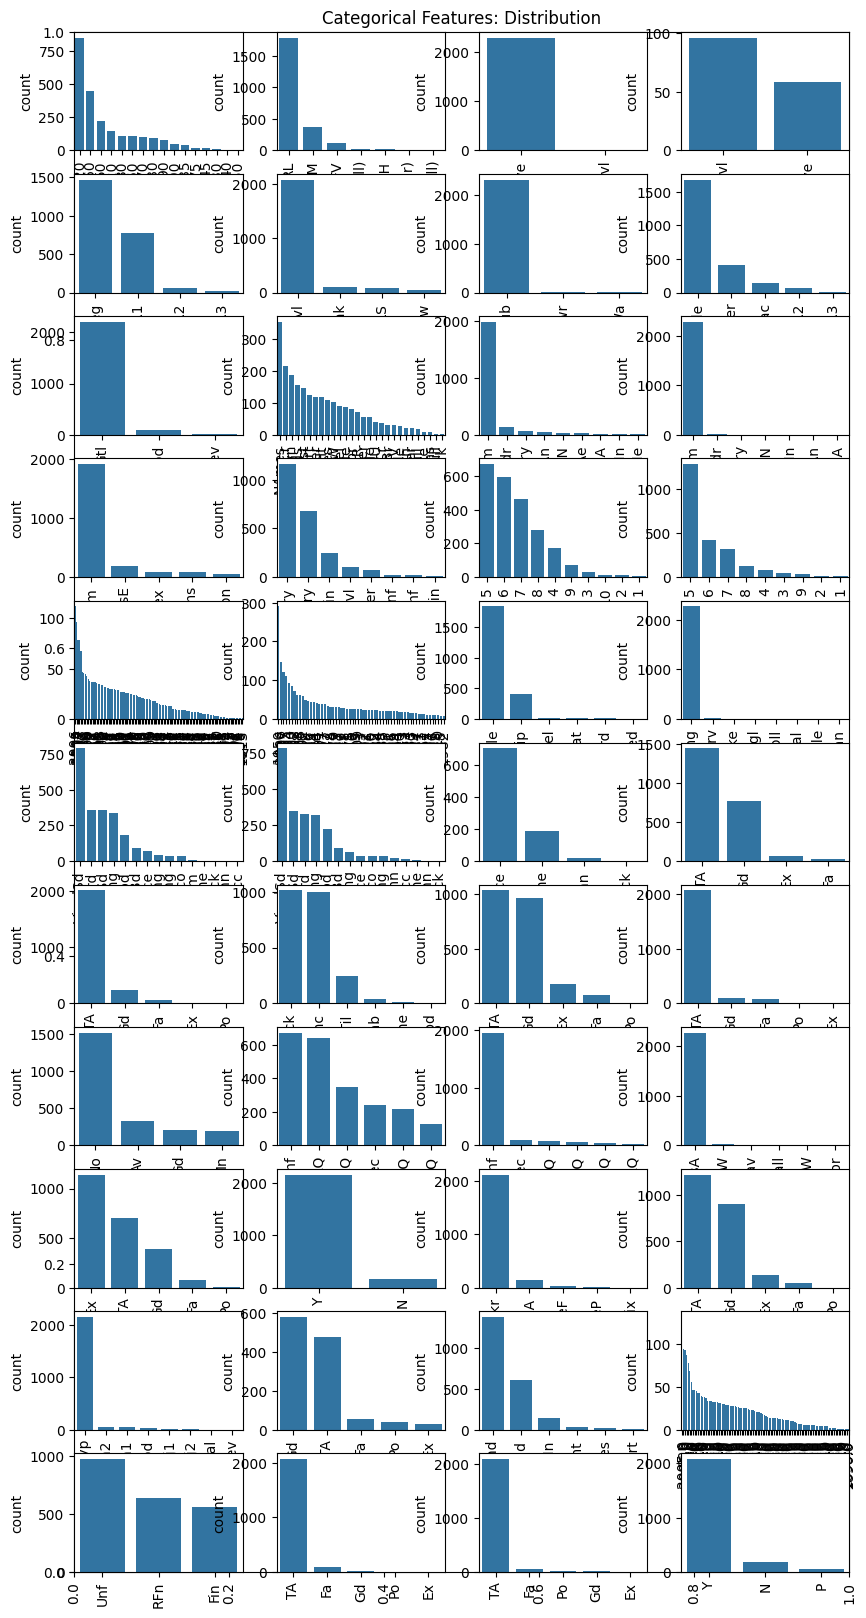

In [27]:
warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 20))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = housing[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [ ]:
housing.shape

(2310, 85)

In [ ]:
housing_test.shape

(575, 85)

In [29]:
#Check for duplicates
boolean = housing.duplicated(subset=['PID']).any()
boolean2 = housing_test.duplicated(subset=['PID']).any()
boolean
boolean2

np.False_

In [30]:
# Missing values check
null_values = housing.isnull().sum()

print(null_values[null_values > 0].sort_values(ascending=False))

Pool QC           2301
Misc Feature      2229
Alley             2156
Fence             1843
Mas Vnr Type      1398
Fireplace Qu      1131
Lot Frontage       389
Garage Cond        132
Garage Qual        132
Garage Finish      132
Garage Type        130
Bsmt Exposure       64
BsmtFin Type 2      62
Bsmt Qual           61
Bsmt Cond           61
BsmtFin Type 1      61
Mas Vnr Area        19
BsmtFin SF 1         1
Bsmt Full Bath       1
Bsmt Half Bath       1
Total Bsmt SF        1
Electrical           1
Bsmt Unf SF          1
BsmtFin SF 2         1
Garage Area          1
Garage Cars          1
dtype: int64


In [31]:
def percent_na(feature, df = housing):
    for val in feature:
        return df[feature].isna().sum()/len(df)

percent_na(list(housing.columns),housing).sort_values(ascending=False).head(28)
percent_na(list(housing_test.columns),housing_test).sort_values(ascending=False).head(28)

,0
Pool QC,0.996522
Misc Feature,0.956522
Alley,0.923478
Fence,0.824348
Mas Vnr Type,0.646957
Fireplace Qu,0.506087
Lot Frontage,0.172174
Garage Qual,0.046957
Garage Type,0.046957
Garage Cond,0.046957


In [32]:
target.isnull().sum()

NameError: name 'target' is not defined

In [33]:
#Deleting those with >80% and unneccesary in both test nad training
housing.drop(['Order', 'PID', 'Pool QC', 'Misc Feature', 'Alley', 'Fence', 'price_cat'], axis=1, inplace=True)
housing_test.drop(['Order', 'PID', 'Pool QC', 'Misc Feature', 'Alley', 'Fence', 'price_cat'], axis=1, inplace=True)

In [ ]:
housing.shape

(2310, 78)

In [ ]:
housing_test.shape

(575, 78)

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 78 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      2319 non-null   object 
 1   MS Zoning        2319 non-null   object 
 2   Lot Frontage     1933 non-null   float64
 3   Lot Area         2319 non-null   int64  
 4   Street           2319 non-null   object 
 5   Lot Shape        2319 non-null   object 
 6   Land Contour     2319 non-null   object 
 7   Utilities        2319 non-null   object 
 8   Lot Config       2319 non-null   object 
 9   Land Slope       2319 non-null   object 
 10  Neighborhood     2319 non-null   object 
 11  Condition 1      2319 non-null   object 
 12  Condition 2      2319 non-null   object 
 13  Bldg Type        2319 non-null   object 
 14  House Style      2319 non-null   object 
 15  Overall Qual     2319 non-null   object 
 16  Overall Cond     2319 non-null   object 
 17  Year Built    

In [34]:
# Further feature engineering
num_pipeline = Pipeline([('num_imputer',SimpleImputer(strategy="median")),
                         ('std_scalar',StandardScaler()),
                         ])

In [35]:
#Pipeline for transforming categorical test/validation later
cat_pipeline = Pipeline([('cat_imputer', SimpleImputer(strategy="constant", fill_value='None')),
                         ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
                        ])

In [36]:
num = housing.select_dtypes(['int64', 'float64'])
cat = housing.select_dtypes(['object', 'category'])

In [37]:
#4. Feature scaling for training set - ML algorithms require features to be on the same scale (except for tree based)
full_pipeline=ColumnTransformer([("num", num_pipeline, list(num)), ("cat", cat_pipeline, list(cat))
                                ])

full_pipeline.set_output(transform='pandas')
housing_train_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_train_prepared.head()

,num__Lot Frontage,num__Lot Area,num__Mas Vnr Area,num__BsmtFin SF 1,num__BsmtFin SF 2,num__Bsmt Unf SF,num__Total Bsmt SF,num__1st Flr SF,num__2nd Flr SF,num__Low Qual Fin SF,...,cat__Sale Type_New,cat__Sale Type_Oth,cat__Sale Type_VWD,cat__Sale Type_WD,cat__Sale Condition_Abnorml,cat__Sale Condition_AdjLand,cat__Sale Condition_Alloca,cat__Sale Condition_Family,cat__Sale Condition_Normal,cat__Sale Condition_Partial
2702,-0.674116,-0.231387,-0.574789,-0.974731,-0.302383,-1.268041,-2.441823,-0.303785,-0.784981,-0.101878,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
625,0.554625,0.604595,0.655809,2.177121,-0.302383,-0.868254,1.235684,1.121504,-0.784981,-0.101878,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2634,0.063129,-0.393524,-0.574789,1.190889,-0.302383,-1.103557,-0.028606,-0.322434,-0.784981,-0.101878,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2306,0.800373,0.064741,0.855049,0.781853,-0.302383,-0.731184,-0.068630,-0.325098,-0.784981,-0.101878,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2209,0.652924,-0.375884,1.903988,0.125122,-0.302383,-0.137214,-0.136906,-0.444982,1.543038,-0.101878,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
housing_train_prepared.isnull().sum()

,0
num__Lot Frontage,0
num__Lot Area,0
num__Mas Vnr Area,0
num__BsmtFin SF 1,0
num__BsmtFin SF 2,0
...,...
cat__Sale Condition_AdjLand,0
cat__Sale Condition_Alloca,0
cat__Sale Condition_Family,0
cat__Sale Condition_Normal,0


In [ ]:
housing_train_prepared.shape

(2310, 624)

In [39]:
#Reuse training pipeline, just transform, don't fit, only used training data to avoid data leakage
full_pipeline.set_output(transform='pandas')
housing_test_prepared = full_pipeline.transform(housing_test)

In [40]:
housing_test_prepared.shape

(575, 624)

In [41]:
housing_train_prepared.rename(columns={'num__SalePrice': 'SalePrice'}, inplace=True)

print(housing_train_prepared['SalePrice'])

2702   -0.675305
625     1.145398
2634   -0.696280
2306   -0.077364
2209   -0.290074
          ...   
2789    1.135723
1142    0.386873
2566    0.147691
1860    2.062910
2206   -1.533762
Name: SalePrice, Length: 2310, dtype: float64


In [42]:
housing_test_prepared.rename(columns={'num__SalePrice': 'SalePrice'}, inplace=True)

print(housing_test_prepared['SalePrice'])

2783    0.177121
2489   -0.185606
97     -0.211298
1060    2.101255
2816   -1.316740
          ...   
1436    0.622166
931     0.813722
2227    0.529608
2200    0.191700
1850    0.579428
Name: SalePrice, Length: 575, dtype: float64


In [43]:
# Feature selection
X_train=housing_train_prepared.drop('SalePrice', axis=1)
y_train=housing_train_prepared['SalePrice']
X_test=housing_test_prepared.drop('SalePrice', axis=1)
y_test=housing_test_prepared['SalePrice']

In [44]:
#High dimensional data - dimensionality reduction
importances = mutual_info_regression(X=housing_train_prepared.drop('SalePrice', axis=1), y=housing_train_prepared['SalePrice'], random_state=42)
feat_importances = pd.Series(importances, housing_train_prepared.columns[0:len(housing_train_prepared.columns)-1])

In [45]:
importances = pd.Series(importances)
importances.index = X_train.columns
sorted = importances.sort_values(ascending=False)

print(sorted.nlargest(20))

num__Gr Liv Area         0.464900
num__Longitude           0.421783
num__Garage Area         0.394943
num__Total Bsmt SF       0.378970
num__Garage Cars         0.377419
num__1st Flr SF          0.339503
num__Latitude            0.329615
num__Full Bath           0.265298
cat__Exter Qual_TA       0.253396
cat__Kitchen Qual_TA     0.221715
num__Lot Frontage        0.220023
cat__Exter Qual_Gd       0.208737
cat__Foundation_PConc    0.204396
num__Open Porch SF       0.192212
num__TotRms AbvGrd       0.189015
num__2nd Flr SF          0.182693
cat__Bsmt Qual_Gd        0.182405
cat__Bsmt Qual_TA        0.171585
cat__Kitchen Qual_Gd     0.170419
num__Lot Area            0.163793
dtype: float64


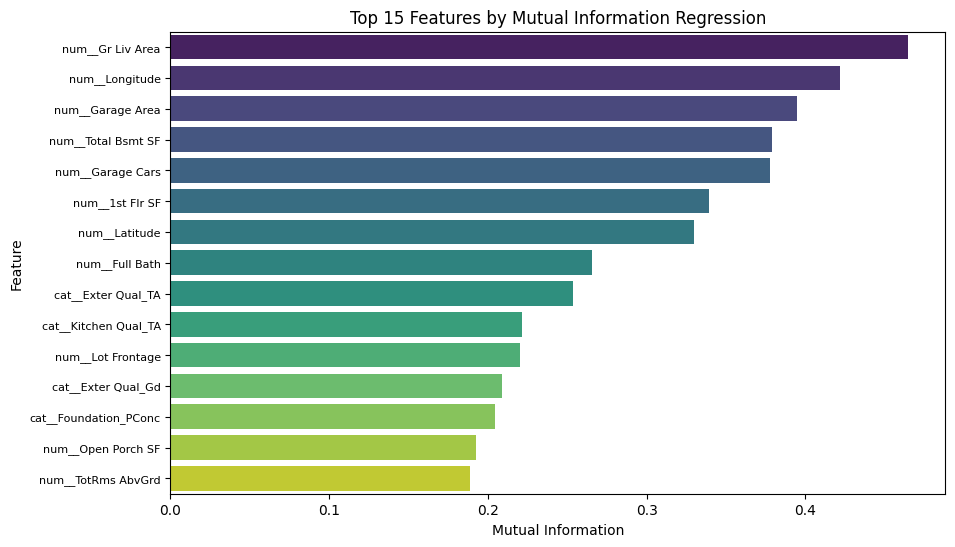

In [46]:
warnings.filterwarnings("ignore")

N = 15
top_features = sorted.nlargest(N)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=top_features.values, y=top_features.index, legend=False, palette='viridis')
barplot.tick_params(axis='y', labelsize=8)
plt.title(f'Top {N} Features by Mutual Information Regression')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.show()

In [47]:
fs = SelectKBest(mutual_info_regression, k='all')
fs.fit(X_train, y_train)
X_train.columns[fs.get_support()]

Index(['num__Lot Frontage', 'num__Lot Area', 'num__Mas Vnr Area',
       'num__BsmtFin SF 1', 'num__BsmtFin SF 2', 'num__Bsmt Unf SF',
       'num__Total Bsmt SF', 'num__1st Flr SF', 'num__2nd Flr SF',
       'num__Low Qual Fin SF',
       ...
       'cat__Sale Type_New', 'cat__Sale Type_Oth', 'cat__Sale Type_VWD',
       'cat__Sale Type_WD ', 'cat__Sale Condition_Abnorml',
       'cat__Sale Condition_AdjLand', 'cat__Sale Condition_Alloca',
       'cat__Sale Condition_Family', 'cat__Sale Condition_Normal',
       'cat__Sale Condition_Partial'],
      dtype='object', length=623)

Feature 0: 0.227413
Feature 1: 0.161874
Feature 2: 0.140827
Feature 3: 0.158805
Feature 4: 0.021408
Feature 5: 0.114662
Feature 6: 0.378278
Feature 7: 0.339262
Feature 8: 0.171181
Feature 9: 0.005341
Feature 10: 0.465974
Feature 11: 0.044820
Feature 12: 0.011597
Feature 13: 0.264973
Feature 14: 0.046213
Feature 15: 0.047752
Feature 16: 0.010925
Feature 17: 0.177796
Feature 18: 0.150987
Feature 19: 0.389013
Feature 20: 0.397214
Feature 21: 0.109376
Feature 22: 0.183144
Feature 23: 0.040130
Feature 24: 0.000000
Feature 25: 0.013387
Feature 26: 0.000000
Feature 27: 0.010461
Feature 28: 0.423620
Feature 29: 0.329693
Feature 30: 0.008091
Feature 31: 0.000000
Feature 32: 0.025913
Feature 33: 0.006619
Feature 34: 0.019551
Feature 35: 0.008105
Feature 36: 0.076566
Feature 37: 0.000000
Feature 38: 0.000000
Feature 39: 0.017726
Feature 40: 0.139870
Feature 41: 0.000000
Feature 42: 0.002613
Feature 43: 0.020315
Feature 44: 0.020575
Feature 45: 0.013916
Feature 46: 0.000000
Feature 47: 0.015640
Fe

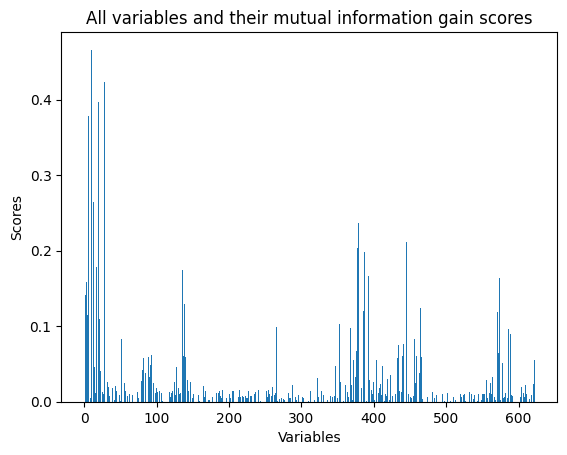

Number of features with scores over 0.05: 75


In [48]:
#We can then print the scores for each variable (largest is better) and plot the scores for each variable as a bar graph to get an idea of how many features we should select.
# Nevertheless, we can see that some variables have larger scores than others, e.g. less than 1 vs. 5, and others have a much larger scores, such as Feature 9 that has 101.
np.random.seed(420)

fs = SelectKBest(mutual_info_regression, k='all')
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
for i in range(len(fs.scores_)):
  print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title(f'All variables and their mutual information gain scores')
plt.xlabel('Variables')
plt.ylabel('Scores')
plt.show()

count_over_005 = sum(score > 0.05 for score in fs.scores_)

print("Number of features with scores over 0.05:", count_over_005)

In [49]:
# Best 75 features

def select_features(X_train, y_train, X_test):
  fs = SelectKBest(score_func=mutual_info_regression, k=75)
  fs.fit(X_train, y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

print(f"X_train_fs shape: {X_train_fs.shape}")
print(f"X_test_fs shape: {X_test_fs.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train_fs shape: (2310, 75)
X_test_fs shape: (575, 75)
X_train shape: (2310, 623)
X_test shape: (575, 623)
y_train shape: (2310,)
y_test shape: (575,)


## Evaluation measures

The performance metrics chosen for evaluating the tuned models were as follows:

Root Mean Square Error (RMSE) – ‘a typical performance measure for regression problems’ (Géron, 2019) that measures the average magnitude of error with which the model makes its predictions. The lower the RMSE value the better the model’s accuracy.

Mean Absolute Error (MAE) – while also an accuracy measure quantifying the average error magnitude, it is particularly recommended if outliers are present in the set, as it treats all errors equally. The lower the MAE value the better the model’s accuracy.

R-squared – a statistical indicator providing information about the goodness-of-fit of the model and the ‘accuracy of its predictions on unseen data samples’ (Sharma et al., 2023). The higher the R2 value the better fit of the model.

Adjusted R-squared – lastly, adjusted R2 works by adjusting the R2 value for the number of predictors in the model, penalizing for adding variables that do not improve the model significantly. The higher the adjusted R2 value the better the fit.

In [50]:
#DEFAULT LASSO
lasso = Lasso(random_state=42)
lasso.fit(X_train_fs, y_train)

print("Training set score: {:.2f}".format(lasso.score(X_train_fs, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test_fs, y_test)))

yhat = lasso.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = lasso.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 0.00
Test set score: -0.00
MAE: 0.757
RMSE: 0.965
R^2: -0.00
Adjusted R^2: -0.15


In [51]:
#DEFAULT RIDGE

ridge = Ridge(random_state=42)
ridge.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(ridge.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(ridge.score(X_test_fs, y_test)))

yhat = ridge.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = ridge.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 0.85
Test set score: 0.85
MAE: 0.261
RMSE: 0.376
R^2: 0.85
Adjusted R^2: 0.83


In [52]:
#DEFAULT RF

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(rf.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(rf.score(X_test_fs, y_test)))

yhat = rf.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = rf.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 0.98
Test set score: 0.85
MAE: 0.256
RMSE: 0.378
R^2: 0.85
Adjusted R^2: 0.82


In [53]:
#DEFAULT ADA

ada = AdaBoostRegressor(random_state=42)

ada.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(ada.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(ada.score(X_test_fs, y_test)))

yhat = ada.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = ada.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 0.77
Test set score: 0.72
MAE: 0.409
RMSE: 0.507
R^2: 0.72
Adjusted R^2: 0.68


In [54]:
#DEFAULT GRADIENT BOOSTING REGRESSOR - best again

gb = GradientBoostingRegressor()

gb.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(gb.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(gb.score(X_test_fs, y_test)))

yhat = gb.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = gb.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 0.92
Test set score: 0.86
MAE: 0.260
RMSE: 0.362
R^2: 0.86
Adjusted R^2: 0.84


In [55]:
#DEFAULT EXTREME GRADIENT BOOSTING

xgb = XGBRegressor()

xgb.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(xgb.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(xgb.score(X_test_fs, y_test)))

yhat = xgb.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = xgb.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

Training set score: 1.00
Test set score: 0.85
MAE: 0.262
RMSE: 0.374
R^2: 0.85
Adjusted R^2: 0.83


In [ ]:
warnings.filterwarnings("ignore")

# HYPERPARAMETER TUNING LASSO

params = {'alpha': (np.logspace(-8, 8, 100))}
lasso = Lasso(random_state=42)
lasso_model = GridSearchCV(lasso, params, cv = 10)
lasso_model.fit(X_train_fs, y_train)
print(lasso_model.best_params_)
print(lasso_model.best_score_)

In [ ]:
#LASSO WITH ALPHA 0.0004862

lasso = Lasso(alpha=0.0004862, random_state=42)
lasso.fit(X_train_fs, y_train)

print("Training set score: {:.2f}".format(lasso.score(X_train_fs, y_train)))
print("Test set score: {:.2f}".format(lasso.score(X_test_fs, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

yhat = lasso.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = lasso.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
#HYPERPARAMETER TUNING RIDGE

params = {'alpha': (np.logspace(-8, 8, 100))}
ridge = Ridge(random_state=42)
ridge_model = GridSearchCV(ridge, params, cv = 10)
ridge_model.fit(X_train_fs, y_train)
print(ridge_model.best_params_)
print(ridge_model.best_score_)

In [ ]:
#RIDGE WITH ALPHA 3.6783797

ridge = Ridge(alpha=3.6783797, random_state=42)
ridge.fit(X_train_fs, y_train)

print("Training set score: {:.2f}".format(ridge.score(X_train_fs, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_test_fs, y_test)))
print("Number of features used: {}".format(np.sum(ridge.coef_ != 0)))

yhat = ridge.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = ridge.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
warnings.filterwarnings("ignore")

#HYPERPARAMETER TUNING RANDOM FOREST

rf_reg = RandomForestRegressor(random_state=42)
rf_param_grid = [
    {'n_estimators': [300,400], 'max_features': [8,16,32], 'max_depth':[4,6,8,10,12,15], 'min_samples_leaf': [1, 2, 4]}]

search_rf = HalvingRandomSearchCV(rf_reg, rf_param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

search_rf.fit(X_train_fs,y_train)

search_rf.best_params_

In [ ]:
# Tuned RF

rf = RandomForestRegressor(random_state=42, n_estimators = 300, max_features = 8, max_depth = 15)
rf.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(rf.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(rf.score(X_test_fs, y_test)))

yhat = rf.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = rf.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
warnings.filterwarnings("ignore")

#HYPERTUNING ADA BOOST

ada_reg = AdaBoostRegressor(random_state=42)

parameters = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01,0.05,0.1,0.3,1]
 }

grid_search_ada = HalvingRandomSearchCV(ada_reg, parameters, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

grid_search_ada.fit(X_train_fs, y_train)

grid_search_ada.best_score_
grid_search_ada.best_estimator_
grid_search_ada.best_params_

In [ ]:
#IMPROVED ADA

ada = AdaBoostRegressor(random_state=42, learning_rate=0.1, n_estimators=200)

ada.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(ada.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(ada.score(X_test_fs, y_test)))

yhat = ada.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = ada.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
#HYPERTUNING GB

gb = GradientBoostingRegressor(random_state=42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01,0.05,0.1,0.3,0.5, 0.8, 1],
    'max_depth' : [3,5,8,10],
 }

gb_search = HalvingRandomSearchCV(gb, parameters, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

gb_search.fit(X_train_fs, y_train)

gb_search.best_estimator_
gb_search.best_params_

In [ ]:
#IMPROVED GB

gb = GradientBoostingRegressor(random_state=42,learning_rate=0.05, max_depth=3)

gb.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(gb.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(gb.score(X_test_fs, y_test)))

yhat = gb.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = gb.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
#HYPERTUNING XGB

xgb = XGBRegressor(random_state=42)

parameters = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01,0.05,0.1,0.3,0.5, 0.8, 1],
    'max_depth' : [3,5,8,10],
 }

xgb_search = HalvingRandomSearchCV(xgb, parameters, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

xgb_search.fit(X_train_fs, y_train)

xgb_search.best_score_
xgb_search.best_estimator_
xgb_search.best_params_

In [ ]:
#IMPROVED XGB

xgb = XGBRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate=0.05)

xgb.fit(X_train_fs, y_train)

print('Training set score: {:.2f}'.format(xgb.score(X_train_fs, y_train)))
print('Test set score: {:.2f}'.format(xgb.score(X_test_fs, y_test)))

yhat = xgb.predict(X_test_fs)

mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = xgb.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2: {:.2f}".format(r_squared))
print("Adjusted R^2: {:.2f}".format(adjusted_r_squared))

In [ ]:
#ENSAMBLE MODEL STACKING

las_pipe = Pipeline([('LassoRegression', Lasso())])
ridge_pipe = Pipeline([('RidgeRegression', Ridge())])
rf_pipe = Pipeline([('RandomForest',RandomForestRegressor())])
ada_pipe = Pipeline([('AdaBoost', AdaBoostRegressor())])
gb_pipe = Pipeline([('GradientBoost', GradientBoostingRegressor())])
xgb_pipe = Pipeline([('ExtremeGradientBoost', XGBRegressor())])

def get_models():
    models = dict()
    models['LA'] = las_pipe
    models['RI'] = ridge_pipe
    models['RF'] = rf_pipe
    models['ADA'] = ada_pipe
    models['GB'] = gb_pipe
    models['XGB'] = xgb_pipe
    return models

def evaluate_model(model,X,y):
    cv = RepeatedKFold(n_splits=10,n_repeats=3,random_state=42)
    scores = cross_val_score(model,X_train_fs,y_train,scoring='neg_mean_squared_error',cv=cv,n_jobs=-1,error_score='raise')
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

models = get_models()
results,names = list(),list()

for name,model in models.items():
    scores = evaluate_model(model, X_train_fs, y_train)
    results.append(scores)
    names.append(name)
    print('>%s RMSE: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

def get_stacking():
    level0 =list()
    level0.append(('LA',Lasso(random_state=42, alpha=0.0004862)))
    level0.append(('RI',Ridge(random_state=42, alpha=3.6783797)))
    level0.append(('RF',RandomForestRegressor(random_state=42, n_estimators=300, max_features=8, max_depth=15)))
    level0.append(('ADA',AdaBoostRegressor(random_state=42, learning_rate=0.1, loss='exponential', n_estimators=160)))
    level0.append(('GB',GradientBoostingRegressor(random_state=42, learning_rate=0.05, max_depth=3)))
    level1=XGBRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate=0.05)
    model = StackingRegressor(estimators=level0,final_estimator=level1,cv=5)
    return model

stack_model = get_stacking()

stack_model.fit(X_train_fs,y_train)

predictions_stack_model = stack_model.predict(X_test_fs)
print(f'RMSE Stacked Model = {np.sqrt(mean_squared_error(y_test,predictions_stack_model))}')

print("Training set score for stacked model: {:.2f}".format(stack_model.score(X_train_fs, y_train)))
print("Test set score for stacked model: {:.2f}".format(stack_model.score(X_test_fs, y_test)))

mae = mean_absolute_error(y_test, predictions_stack_model)
mse = mean_squared_error(y_test, predictions_stack_model)
rmse = np.sqrt(mse)

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)

n = X_test_fs.shape[0]
p = X_test_fs.shape[1]
r_squared = stack_model.score(X_test_fs, y_test)
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R^2 stack model: {:.2f}".format(r_squared))
print("Adjusted R^2 stack model: {:.2f}".format(adjusted_r_squared))

## Results

To make sure that the performance of models is as good as it can get, hyperparameter automatic search modules – GridSearchCV and HalvingRandomSearchCV, were used to find the best values for each specific model. A 10-fold cross-validation and the above metrics were chosen to measure the performance of each model after hypertuning the parameters.

AdaBoost is characterised by overall worst performance, while the
Stacking Model and Extreme Gradient Boosting perform best, which confirms the findings by Sharma et al., who argued that the latter is an ‘optimal model for house price prediction’ (2023). The elevated training set score for Random Forest is the result of its structure and the ensemble learning approach it utilizes, meaning that the difference between training and test scores of Random Forest does not necessarily mean it is overfitting.

## Ethics
Based on the deprecation of the highly comparable Boston housing dataset since it assumed that racial self-segregation affects house prices, it is now known that even a housing-related machine learning model could be biased and produce prejudiced results. It is therefore important to bear in mind the ethical considerations when creating machine learning models, as potentially our model could further exacerbate existing inequalities and discriminatory
practices, or as in the case of the Boston housing dataset, systematically undervalue properties in minority neighbourhoods.

## Conclusion

Throughout this report, numerous machine learning algorithms were explored, ultimately identifying the Extreme Gradient Boosting and Stacking Model as the best-performing models. The adoption of the former for contemporary social issues can provide valuable tools and insights to those struggling with housing affordability. By leveraging their advanced predictive capabilities, a move towards a more equitable and accessible housing market for all is possible.

## References

Ahrens, A., Ersoy, E., Iakovlev, V., Li, H. and Schaffer, M. E., 2022. An Introduction to Stacking Regression for Economists. In Credible Asset Allocation, Optimal Transport Methods, and Related Topics. TES 2022. Studies in Systems, Decision and Control, Vol. 429, pp. 7 - 29.

Brocker, C., 2024. Ames hopes to use more than $800,000 in grants to curb rising rent costs. Ames Tribune, 22th March. Available at: https://eu.amestrib.com/story/news/local/2024/03/22/ames-officials-want-to-use-more-than-800k-in-federal-funding-for-housing/73028928007/ (Accessed on: 21/05/2024).

Fan, C., Cui, Z., and Zhong, X. House prices prediction with machine learning algorithms. In Proceedings of the 2018 10th International Conference on Machine Learning and Computing, Macau, China, 26-28 February 2018, pp. 89-93.

Géron, A., 2019. Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. Sebastopol, CA: O’Reilly Media, Inc.

Graczyk, M., Lasota, T., Trawiński, B. and Trawiński, K., 2010. Comparison of bagging, boosting and stacking ensembles applied to real estate appraisal. In Asian conference on intelligent information and database systems. Springer, pp. 340 – 350.

Head, T., 2024. Back to the 19th century: Houses in UK ‘at their most unaffordable’ since 1876. The London Economic, 21st of January. Available at: https://www.thelondoneconomic.com/news-average-house-prices-uk-houses-unaffordable-2024-366875/ (Accessed on: 21/05/2024).

Jones, R., 2023. Income to house price ratio more than doubles since the 70s. Financial Reporter, 5th July. Available at: https://www.financialreporter.co.uk/income-to-house-price-ratio-more-than-doubles-since-the-70s.html#:~:text=House%20prices%20are%20currently%20sitting,today%20after%20adjusting%20for%20inflation (Accessed on: 21/05/2024).

Müller, A. C. and Guido, S., 2017. Introduction to Machine Learning with Python: A guide for Data Scientists. Sebastopol, CA: O’Reilly Media, Inc.

Ozdemir, S. and Susarla, D., 2018. Feature Engineering Made Easy: Identify unique features from your dataset in order to build powerful machine learning systems. Birmingham: Packt Publishing.

Sharma, H., Harsora, H. and Ogunleye, B., 2023. An Optimal House Price Prediction Algorithm: XGBoost. Analytics, Vol. 3, pp. 30 – 45.

Shrestha, N., 2020. Detecting Multicollinearity in Regression Analysis. American Journal of Applied Mathematics and Statistics, Vol. 8 (2), pp. 39 – 42.

Thatcher, M., 1987. Interview for ‘Woman’s Own’. In Margaret Thatcher Foundation: Speeches, Interviews and Other Statements. London.

Tukey, J. W., 1977. Exploratory Data Analysis. Reading, MA: Addison-Wesley Pub, Co. United States Census Bureau, 2023. American Community Survey 5-Year Data (2009-2022). Available at: https://www.census.gov/data/developers/data-sets/acs-5year.html (Accessed on: 21/05/2024).

Wade, C. and Glynn, K., 2020. Gradient Boosting with XGBoost and scikit-learn: Perform accessible machine learning and extreme gradient boosting in Python. Birmingham: Packt Publishing.

Wolpert, D. H., 1992. Stacked generalisation. In Neural networks 5.2, pp. 241 – 259.
